In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/malimg/malimg_dataset/val/Lolyda.AA3/00b7419d6e37cc73531a9354d6de8910.png
/kaggle/input/malimg/malimg_dataset/val/Lolyda.AA3/005b438811c6551f1010829646a32918.png
/kaggle/input/malimg/malimg_dataset/val/Lolyda.AA3/00e7521624fce837f1bc1d820a628ced.png
/kaggle/input/malimg/malimg_dataset/val/Lolyda.AA3/0080e7f7435609fd07b185bd5400c898.png
/kaggle/input/malimg/malimg_dataset/val/Lolyda.AA3/0170c44cac1ee45936c21df8cb44807b.png
/kaggle/input/malimg/malimg_dataset/val/Lolyda.AA3/007618e8258e26e2d301db7f58271ff1.png
/kaggle/input/malimg/malimg_dataset/val/Lolyda.AA3/00e1e7804975da1a6558309c5b834caa.png
/kaggle/input/malimg/malimg_dataset/val/Lolyda.AA3/00b9538e6b1043351903b42359aed1e4.png
/kaggle/input/malimg/malimg_dataset/val/Lolyda.AA3/00419600c9ab8881a1395fdb19a706a9.png
/kaggle/input/malimg/malimg_dataset/val/Lolyda.AA3/00cb9c74fca4562613aa88ebd0519bd1.png
/kaggle/input/malimg/malimg_dataset/val/Lolyda.AA3/002393ed3b19333292074f99cc402c69.png
/kaggle/input/malimg/malimg_data

In [2]:
pip install torch torchvision timm numpy scikit-learn matplotlib


Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from collections import Counter

# Define dataset path
DATASET_PATH = "/kaggle/input/malimg/malimg_dataset"

# Define image transformations for ViT
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.Resize((224, 224)),  # ViT requires a fixed input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1,1]
])

# Load all datasets
train_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "train"), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "val"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "test"), transform=transform)

# Verify that class indices are consistent across datasets
assert train_dataset.class_to_idx == val_dataset.class_to_idx == test_dataset.class_to_idx, "Class indices are not consistent across datasets"

# Get class names
class_names = train_dataset.classes

# Function to count samples per class
def count_samples_per_class(dataset):
    counts = {class_name: 0 for class_name in class_names}
    for _, label in dataset.samples:
        counts[class_names[label]] += 1
    return counts

# Count original samples per class in each dataset
train_counts_original = count_samples_per_class(train_dataset)
val_counts_original = count_samples_per_class(val_dataset)
test_counts_original = count_samples_per_class(test_dataset)

# Determine which classes to keep (classes with ≥75 samples in train)
# Determine which classes to keep (classes with ≥98 samples in train) and exclude "Swizzor.gen!E"
classes_to_keep = [
    class_name for class_name, count in train_counts_original.items()
    if count >= 97 and class_name != "Swizzor.gen!E"
]

print(f"Keeping {len(classes_to_keep)} classes out of {len(class_names)}")
print(f"Classes to keep: {classes_to_keep}")

# Function to filter dataset by classes and apply max cap
def filter_dataset(dataset, classes_to_keep, max_samples_per_class=None):
    class_sample_counts = {class_name: 0 for class_name in classes_to_keep}
    filtered_indices = []
    
    for idx, (_, label) in enumerate(dataset.samples):
        class_name = class_names[label]
        if class_name not in classes_to_keep:
            continue
        
        if max_samples_per_class and class_sample_counts[class_name] >= max_samples_per_class:
            continue
            
        filtered_indices.append(idx)
        class_sample_counts[class_name] += 1
    
    return Subset(dataset, filtered_indices), class_sample_counts

# Filter and balance datasets
train_dataset_balanced, train_counts_balanced = filter_dataset(train_dataset, classes_to_keep, 100)
val_dataset_filtered, val_counts_filtered = filter_dataset(val_dataset, classes_to_keep, 15)  # Clip val to 40
test_dataset_filtered, test_counts_filtered = filter_dataset(test_dataset, classes_to_keep, 15)  # Clip test to 40

# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset_balanced, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_filtered, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset_filtered, batch_size=BATCH_SIZE, shuffle=False)

# Print dataset statistics
def print_dataset_stats(name, original_size, filtered_size, original_counts, filtered_counts):
    print(f"\n{name.upper()} DATASET:")
    print(f"Original size: {original_size}")
    print(f"Filtered size: {filtered_size}")
    print(f"Classes before filtering: {len([c for c, count in original_counts.items() if count > 0])}")
    print(f"Classes after filtering: {len([c for c, count in filtered_counts.items() if count > 0])}")
    
    print(f"\nSample counts per class BEFORE filtering:")
    for class_name in sorted(original_counts.keys()):
        if original_counts[class_name] > 0:
            print(f"  {class_name}: {original_counts[class_name]}")
    
    print(f"\nSample counts per class AFTER filtering:")
    for class_name in sorted(filtered_counts.keys()):
        if filtered_counts[class_name] > 0:
            print(f"  {class_name}: {filtered_counts[class_name]}")

# Print statistics for all datasets
print_dataset_stats(
    "Train", 
    len(train_dataset), 
    len(train_dataset_balanced), 
    train_counts_original, 
    train_counts_balanced
)

print_dataset_stats(
    "Validation", 
    len(val_dataset), 
    len(val_dataset_filtered), 
    val_counts_original, 
    val_counts_filtered
)

print_dataset_stats(
    "Test", 
    len(test_dataset), 
    len(test_dataset_filtered), 
    test_counts_original, 
    test_counts_filtered
)

# Print final counts in a tabular format for easy comparison
print("\nFINAL SAMPLE COUNTS PER CLASS ACROSS ALL DATASETS:")
print(f"{'Class Name':<25} {'Train':<8} {'Val':<8} {'Test':<8} {'Total':<8}")
print("-" * 60)
for class_name in sorted(classes_to_keep):
    train_count = train_counts_balanced.get(class_name, 0)
    val_count = val_counts_filtered.get(class_name, 0)
    test_count = test_counts_filtered.get(class_name, 0)
    total = train_count + val_count + test_count
    print(f"{class_name:<25} {train_count:<8} {val_count:<8} {test_count:<8} {total:<8}")

# Print overall summary
print("\nSUMMARY:")
print(f"Total original samples: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")
print(f"Total filtered samples: {len(train_dataset_balanced) + len(val_dataset_filtered) + len(test_dataset_filtered)}")
print(f"Classes retained: {len(classes_to_keep)} out of {len(class_names)}")

# Distribution analysis
train_total = sum(train_counts_balanced.values())
val_total = sum(val_counts_filtered.values())
test_total = sum(test_counts_filtered.values())

print(f"\nDATASET DISTRIBUTION:")
print(f"Train: {train_total} samples ({train_total/(train_total+val_total+test_total)*100:.1f}%)")
print(f"Validation: {val_total} samples ({val_total/(train_total+val_total+test_total)*100:.1f}%)")
print(f"Test: {test_total} samples ({test_total/(train_total+val_total+test_total)*100:.1f}%)")

Keeping 20 classes out of 25
Classes to keep: ['Adialer.C', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Swizzor.gen!I', 'VB.AT', 'Yuner.A']

TRAIN DATASET:
Original size: 7459
Filtered size: 1995
Classes before filtering: 25
Classes after filtering: 20

Sample counts per class BEFORE filtering:
  Adialer.C: 97
  Agent.FYI: 92
  Allaple.A: 2359
  Allaple.L: 1272
  Alueron.gen!J: 158
  Autorun.K: 84
  C2LOP.P: 116
  C2LOP.gen!g: 160
  Dialplatform.B: 141
  Dontovo.A: 129
  Fakerean: 304
  Instantaccess: 344
  Lolyda.AA1: 170
  Lolyda.AA2: 147
  Lolyda.AA3: 98
  Lolyda.AT: 127
  Malex.gen!J: 108
  Obfuscator.AD: 113
  Rbot!gen: 126
  Skintrim.N: 64
  Swizzor.gen!E: 102
  Swizzor.gen!I: 105
  VB.AT: 326
  Wintrim.BX: 77
  Yuner.A: 640

Sample counts per class AFTER filtering:
  Adialer.C: 97
  Allaple.A: 100

In [4]:
import shutil
import os

# Define new dataset path
FILTERED_DATASET_PATH = "/kaggle/working/filtered_malimg"

# Function to create directories and copy filtered samples
def create_filtered_dataset(original_dataset_path, filtered_dataset, dataset_type):
    filtered_path = os.path.join(FILTERED_DATASET_PATH, dataset_type)
    os.makedirs(filtered_path, exist_ok=True)

    # Create class subdirectories
    for class_name in classes_to_keep:
        os.makedirs(os.path.join(filtered_path, class_name), exist_ok=True)

    # Copy images
    for idx in filtered_dataset.indices:
        img_path, label = original_dataset_path.samples[idx]
        class_name = class_names[label]
        dest_path = os.path.join(filtered_path, class_name, os.path.basename(img_path))
        shutil.copy(img_path, dest_path)

# Create and copy datasets
create_filtered_dataset(train_dataset, train_dataset_balanced, "train")
create_filtered_dataset(val_dataset, val_dataset_filtered, "val")
create_filtered_dataset(test_dataset, test_dataset_filtered, "test")

print("Filtered dataset is saved in:", FILTERED_DATASET_PATH)


Filtered dataset is saved in: /kaggle/working/filtered_malimg


In [5]:
!mkdir -p /kaggle/working/output
!cp -r /kaggle/working/filtered_malimg /kaggle/working/output/



In [6]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define dataset path
DATASET_PATH = "/kaggle/working/filtered_malimg"

# Define image transformations for ViT
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.Resize((224, 224)),  # ViT requires a fixed input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1,1]
])

# Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "train"), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "val"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "test"), transform=transform)

# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check dataset details
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")



Training samples: 1995
Validation samples: 288
Testing samples: 295
Classes: ['Adialer.C', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Swizzor.gen!I', 'VB.AT', 'Yuner.A']


In [7]:
import timm
import torch.nn as nn
import torch.optim as optim

# Load a pretrained Vision Transformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(train_dataset.classes))

# Move model to device
vit_model = vit_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit_model.parameters(), lr=3e-4, weight_decay=1e-4)


In [8]:
def train_vit(model, train_loader, val_loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate_vit(model, val_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")



import torch
from collections import defaultdict
from sklearn.metrics import precision_score, f1_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, f1_score, confusion_matrix

import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd
from sklearn.metrics import precision_score, f1_score, confusion_matrix

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os

def evaluate_vit_by_family(model, test_loader, test_dataset, save_path="confusion_matrix.png"):
    model.eval()
    family_correct = defaultdict(int)
    family_total = defaultdict(int)
    family_preds = defaultdict(list)
    family_labels = defaultdict(list)
    all_preds = []
    all_labels = []
    all_correct, all_total = 0, 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            for label, pred in zip(labels, predicted):
                class_name = test_dataset.classes[label]
                family_total[class_name] += 1
                family_correct[class_name] += (pred == label).item()
                family_preds[class_name].append(pred.item())
                family_labels[class_name].append(label.item())
                
                all_preds.append(pred.item())
                all_labels.append(label.item())
                
                all_total += 1
                all_correct += (pred == label).item()
    
    overall_acc = all_correct / all_total if all_total > 0 else 0
    
    results = []
    for family, total in family_total.items():
        acc = family_correct[family] / total if total > 0 else 0
        precision = precision_score(family_labels[family], family_preds[family], average='macro', zero_division=0)
        recall = recall_score(family_labels[family], family_preds[family], average='macro', zero_division=0)
        f1 = f1_score(family_labels[family], family_preds[family], average='macro', zero_division=0)
        results.append([family, acc, precision, recall, f1])

    df_results = pd.DataFrame(results, columns=["Family", "Accuracy", "Precision", "Recall", "F1 Score"])
    df_results = df_results.sort_values(by="Accuracy", ascending=False)
    
    print("\n📊 Accuracy per family:")
    print(df_results.to_string(index=False))
    print(f"\n✅ Overall Accuracy: {overall_acc:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(test_dataset.classes))))
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    
    # Save confusion matrix image
    plt.tight_layout()
    plt.savefig(save_path)
    print(f"\n📥 Confusion matrix saved to: {os.path.abspath(save_path)}")
    plt.show()
    
    return overall_acc, df_results

  

    
    


    

    



    

    


In [9]:
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # For better progress visualization

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Since we're using all classes, we don't need to filter the dataset
# Just create DataLoaders directly from the full datasets
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit_model.parameters(), lr=3e-4, weight_decay=1e-4)

# Print information about the training setup
print(f"✅ Training on all {len(train_dataset.classes)} malware families")
print(f"📊 Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

# Training function with progress tracking
def train_vit_with_progress(model, train_loader, val_loader, epochs=5, print_every=10):
    model.train()
    
    for epoch in range(epochs):
        print(f"\n🚀 Epoch [{epoch+1}/{epochs}]")
        total_loss = 0
        correct, total = 0, 0
        
        # Use tqdm for progress tracking
        batch_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")
        for batch_idx, (images, labels) in batch_iterator:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            # Print progress every N batches
            if (batch_idx + 1) % print_every == 0:
                batch_acc = correct / total
                batch_iterator.set_postfix(loss=total_loss / (batch_idx + 1), acc=batch_acc)
        # Compute training and validation accuracy
        train_acc = correct / total
        val_acc = evaluate_vit(model, val_loader)
        print(f"📊 Epoch {epoch+1}: Loss: {total_loss / len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Validation function
def evaluate_vit(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Train ViT with Progress Tracking
train_vit_with_progress(vit_model, train_loader, val_loader, epochs=5, print_every=10)

✅ Training on all 20 malware families
📊 Training samples: 1995, Validation samples: 288

🚀 Epoch [1/5]


Training: 100%|██████████| 63/63 [01:15<00:00,  1.20s/it, acc=0.39, loss=1.96]  


📊 Epoch 1: Loss: 1.8958, Train Acc: 0.4070, Val Acc: 0.9132

🚀 Epoch [2/5]


Training: 100%|██████████| 63/63 [01:15<00:00,  1.19s/it, acc=0.908, loss=0.345]


📊 Epoch 2: Loss: 0.3377, Train Acc: 0.9093, Val Acc: 0.9514

🚀 Epoch [3/5]


Training: 100%|██████████| 63/63 [01:15<00:00,  1.19s/it, acc=0.965, loss=0.147]


📊 Epoch 3: Loss: 0.1456, Train Acc: 0.9639, Val Acc: 0.9444

🚀 Epoch [4/5]


Training: 100%|██████████| 63/63 [01:15<00:00,  1.19s/it, acc=0.946, loss=0.168]


📊 Epoch 4: Loss: 0.1730, Train Acc: 0.9464, Val Acc: 0.9306

🚀 Epoch [5/5]


Training: 100%|██████████| 63/63 [01:15<00:00,  1.19s/it, acc=0.974, loss=0.0915]


📊 Epoch 5: Loss: 0.0881, Train Acc: 0.9754, Val Acc: 0.9722



📊 Accuracy per family:
        Family  Accuracy  Precision   Recall  F1 Score
     Adialer.C  1.000000        1.0 1.000000  1.000000
     Allaple.A  1.000000        1.0 1.000000  1.000000
     Allaple.L  1.000000        1.0 1.000000  1.000000
 Alueron.gen!J  1.000000        1.0 1.000000  1.000000
   C2LOP.gen!g  1.000000        1.0 1.000000  1.000000
Dialplatform.B  1.000000        1.0 1.000000  1.000000
     Dontovo.A  1.000000        1.0 1.000000  1.000000
      Fakerean  1.000000        1.0 1.000000  1.000000
    Lolyda.AA1  1.000000        1.0 1.000000  1.000000
 Instantaccess  1.000000        1.0 1.000000  1.000000
    Lolyda.AA2  1.000000        1.0 1.000000  1.000000
    Lolyda.AA3  1.000000        1.0 1.000000  1.000000
      Rbot!gen  1.000000        1.0 1.000000  1.000000
     Lolyda.AT  1.000000        1.0 1.000000  1.000000
   Malex.gen!J  1.000000        1.0 1.000000  1.000000
 Obfuscator.AD  1.000000        1.0 1.000000  1.000000
       Yuner.A  1.000000        1.0 1.000

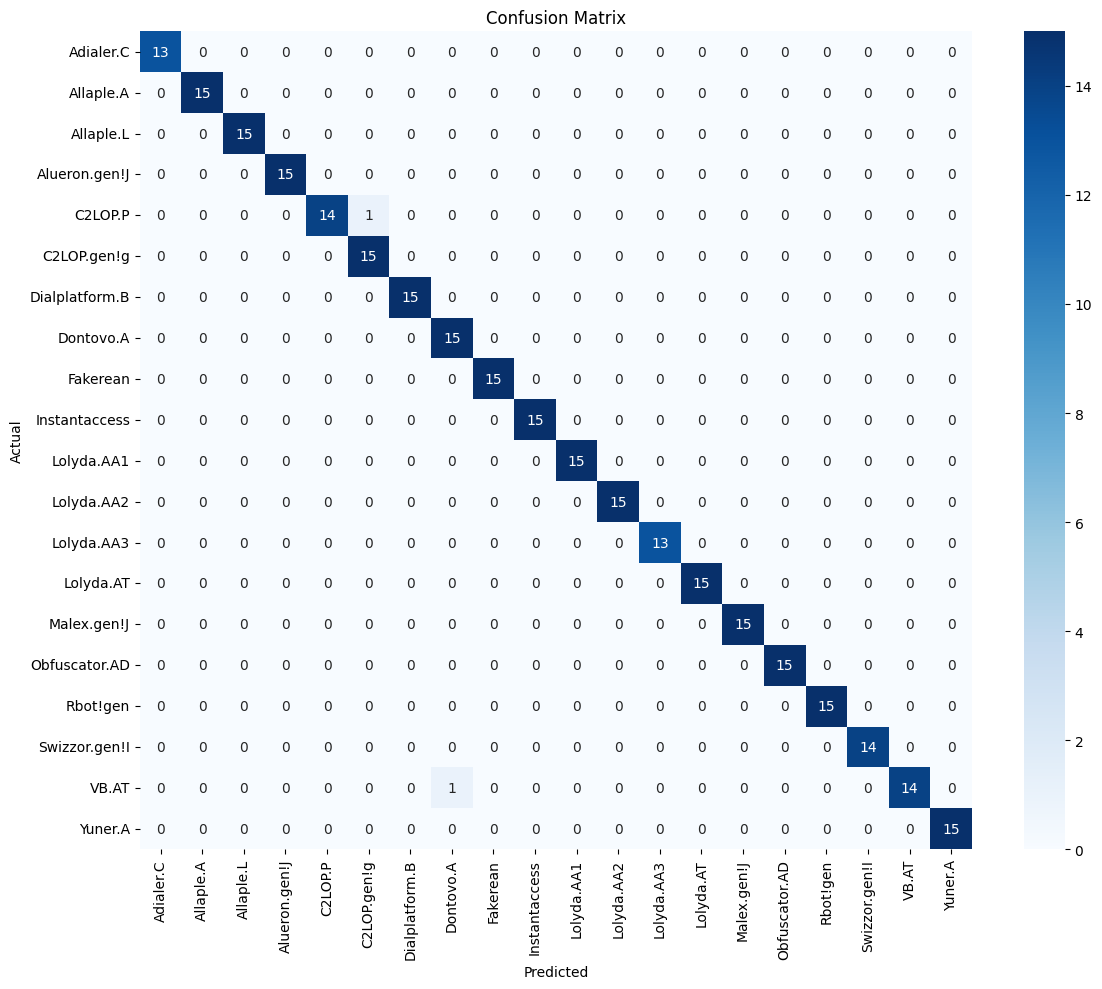

In [10]:
overall_acc, results_df = evaluate_vit_by_family(vit_model, test_loader, test_dataset, "/kaggle/working/original.png")

In [11]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# import timm
# import numpy as np
# import random
# from tqdm import tqdm
# import matplotlib.pyplot as plt

# # Set seeds for reproducibility
# def set_seed(seed=42):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True

# set_seed()

# # Device configuration
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Define dataset path
# DATASET_PATH = "/kaggle/working/filtered_malimg"

# # Define image transformations
# transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
#     transforms.Resize((224, 224)),  # ViT requires a fixed input size
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1,1]
# ])

# # Load datasets
# train_dataset = datasets.ImageFolder(root=f"{DATASET_PATH}/train", transform=transform)
# val_dataset = datasets.ImageFolder(root=f"{DATASET_PATH}/val", transform=transform)
# test_dataset = datasets.ImageFolder(root=f"{DATASET_PATH}/test", transform=transform)

# # Create DataLoaders
# BATCH_SIZE = 32
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# print(f"Training samples: {len(train_dataset)}")
# print(f"Validation samples: {len(val_dataset)}")
# print(f"Testing samples: {len(test_dataset)}")
# print(f"Number of classes: {len(train_dataset.classes)}")

# # Define the Masked Autoencoder model
# class MaskedAutoencoder(nn.Module):
#     def __init__(self, base_encoder='vit_base_patch16_224', img_size=224, patch_size=16,
#                  mask_ratio=0.75, norm_pix_loss=True, num_classes=0):
#         super().__init__()
#         self.img_size = img_size
#         self.patch_size = patch_size
#         self.mask_ratio = mask_ratio
#         self.norm_pix_loss = norm_pix_loss
        
#         # Number of patches (N)
#         self.num_patches = (img_size // patch_size) ** 2
        
#         # Encoder: backbone + projection head
#         self.encoder = timm.create_model(
#             base_encoder, 
#             pretrained=True,
#             img_size=img_size,
#             num_classes=0  # remove classifier head
#         )
        
#         # Set encoder to return attention tokens
#         self.encoder.forward_features = self.encoder.forward_features
        
#         # Dimensions
#         embed_dim = self.encoder.embed_dim
        
#         # Decoder part
#         self.decoder_embed = nn.Linear(embed_dim, embed_dim // 2, bias=True)
        
#         # Add position embeddings to the decoder
#         self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim // 2))
        
#         # Decoder transformer blocks
#         self.decoder_blocks = nn.ModuleList([
#             nn.TransformerEncoderLayer(d_model=embed_dim // 2, nhead=8, 
#                                       dim_feedforward=embed_dim * 2, dropout=0.1, 
#                                       activation='gelu', batch_first=True)
#             for _ in range(4)  # 4 transformer blocks for decoder
#         ])
        
#         # Decoder output
#         self.decoder_norm = nn.LayerNorm(embed_dim // 2)
#         self.decoder_pred = nn.Linear(embed_dim // 2, patch_size**2 * 3, bias=True)  # 3 channels for RGB
        
#         # Classifier head (if needed)
#         self.num_classes = num_classes
#         if num_classes > 0:
#             self.classifier = nn.Linear(embed_dim, num_classes)
        
#         # Initialize weights
#         self.initialize_weights()
    
#     def initialize_weights(self):
#         # Initialize decoder position embeddings
#         torch.nn.init.normal_(self.decoder_pos_embed, std=0.02)
        
#         # Initialize decoder projection
#         nn.init.xavier_uniform_(self.decoder_embed.weight)
#         if self.decoder_embed.bias is not None:
#             nn.init.constant_(self.decoder_embed.bias, 0)
            
#         # Initialize decoder prediction
#         nn.init.xavier_uniform_(self.decoder_pred.weight)
#         if self.decoder_pred.bias is not None:
#             nn.init.constant_(self.decoder_pred.bias, 0)
            
#         # Initialize classifier if exists
#         if self.num_classes > 0:
#             nn.init.xavier_uniform_(self.classifier.weight)
#             nn.init.constant_(self.classifier.bias, 0)
    
#     def random_masking(self, x, mask_ratio):
#         """
#         Perform per-sample random masking by per-sample shuffling.
#         x: [N, L, D], sequence
#         """
#         N, L, D = x.shape  # batch, length, dim
#         len_keep = int(L * (1 - mask_ratio))
        
#         noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
#         # Sort noise for each sample
#         ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
#         ids_restore = torch.argsort(ids_shuffle, dim=1)  # restore indices
        
#         # Keep the first len_keep indices (the CLS token is at index 0)
#         # Keep CLS token (first token) and other random tokens
#         ids_keep = ids_shuffle[:, :len_keep]
#         x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
        
#         # Generate the binary mask: 0 is keep, 1 is remove
#         mask = torch.ones([N, L], device=x.device)
#         mask.scatter_(1, ids_keep, 0)
        
#         return x_masked, mask, ids_restore
    
#     def forward_encoder(self, x, mask_ratio):
#         # Get patch embeddings from the encoder
#         x = self.encoder.patch_embed(x)
        
#         # Add position embeddings
#         x = x + self.encoder.pos_embed.type_as(x)[:, 1:, :]
        
#         # Apply masking
#         x, mask, ids_restore = self.random_masking(x, mask_ratio)
        
#         # Extract CLS token from the encoder 
#         cls_token = self.encoder.cls_token.expand(x.shape[0], -1, -1)
        
#         # Append CLS token
#         x = torch.cat((cls_token, x), dim=1)
        
#         # Apply Transformer blocks
#         for blk in self.encoder.blocks:
#             x = blk(x)
        
#         # Apply normalization
#         x = self.encoder.norm(x)
        
#         return x, mask, ids_restore
    
#     def forward_decoder(self, x, ids_restore):
#         # Embed tokens
#         x = self.decoder_embed(x)
    
#         # The shape issue occurs here - we need to properly reconstruct the full sequence
    
#         # Calculate dimensions
#         B = x.shape[0]  # Batch size
#         L_full = self.num_patches  # Number of patches in full image
#         D = x.shape[2]  # Embedding dimension after decoder_embed
    
#         # Extract the cls token and the rest
#         cls_token = x[:, 0:1, :]
#         x_ = x[:, 1:, :]  # Remove CLS token
    
#         # Create mask tokens
#         mask_tokens = torch.zeros([B, L_full + 1 - x_.shape[1], D], device=x.device)
    
#         # Concatenate visible tokens with mask tokens
#         x_ = torch.cat([x_, mask_tokens], dim=1)  # [B, L_full, D]
    
#         # Unshuffle using ids_restore
#         x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, D))
    
#         # Add positional embeddings
#         x_ = x_ + self.decoder_pos_embed[:, 1:, :]
    
#         # Add CLS token back
#         x = torch.cat([cls_token, x_], dim=1)
    
#         # Apply Transformer blocks
#         for blk in self.decoder_blocks:
#             x = blk(x)
    
#         # Apply normalization
#         x = self.decoder_norm(x)
    
#         # Remove CLS token for prediction
#         x = x[:, 1:, :]
    
#         # Predict pixel values for each patch
#         x = self.decoder_pred(x)
    
#         return x
   
    
#     def patchify(self, imgs):
#         """
#         imgs: (N, 3, H, W)
#         x: (N, L, patch_size**2 *3)
#         """
#         p = self.patch_size
#         assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0
        
#         h = w = imgs.shape[2] // p
#         x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
#         x = torch.einsum('nchpwq->nhwpqc', x)
#         x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
#         return x
    
#     def unpatchify(self, x):
#         """
#         x: (N, L, patch_size**2 *3)
#         imgs: (N, 3, H, W)
#         """
#         p = self.patch_size
#         h = w = int(x.shape[1]**.5)
#         assert h * w == x.shape[1]
        
#         x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
#         x = torch.einsum('nhwpqc->nchpwq', x)
#         imgs = x.reshape(shape=(x.shape[0], 3, h * p, w * p))
#         return imgs
    
#     def forward_loss(self, imgs, pred, mask):
#         """
#         imgs: [N, 3, H, W]
#         pred: [N, L, p*p*3]
#         mask: [N, L], 0 is keep, 1 is remove, 
#         """
#         target = self.patchify(imgs)
        
#         if self.norm_pix_loss:
#             mean = target.mean(dim=-1, keepdim=True)
#             var = target.var(dim=-1, keepdim=True)
#             target = (target - mean) / (var + 1.e-6)**.5
        
#         loss = (pred - target) ** 2
#         loss = loss.mean(dim=-1)  # [N, L], mean loss per patch
        
#         # Compute mean loss on masked patches
#         loss = (loss * mask).sum() / mask.sum()
#         return loss
    
#     def forward(self, imgs, mask_ratio=None):
#         """
#         Forward function for training MAE or using as a classifier
#         """
#         if mask_ratio is not None:  # Training MAE
#             latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
#             pred = self.forward_decoder(latent, ids_restore)
#             return pred, mask, latent[:, 0]  # [B, L, p*p*3], [B, L], [B, D]
#         else:  # Using as classifier
#             features = self.encoder.forward_features(imgs)  # [B, D]
#             if self.num_classes > 0:
#                 return self.classifier(features[:, 0])  # Use CLS token for classification
#             else:
#                 return features[:, 0]  # Return CLS token embedding

# # Function to train the Masked Autoencoder
# def train_mae(model, train_loader, optimizer, epoch, device, mask_ratio=0.75):
#     model.train()
#     total_loss = 0
    
#     progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), 
#                         desc=f"MAE Train Epoch {epoch}")
    
#     for batch_idx, (data, _) in progress_bar:
#         data = data.to(device)
#         optimizer.zero_grad()
        
#         # Forward pass
#         pred, mask, _ = model(data, mask_ratio=mask_ratio)
        
#         # Compute reconstruction loss
#         loss = model.forward_loss(data, pred, mask)
        
#         # Backward pass
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
        
#         # Update progress bar
#         progress_bar.set_postfix({"Loss": total_loss / (batch_idx + 1)})
    
#     return total_loss / len(train_loader)

# # Function to visualize reconstructions
# def visualize_reconstructions(model, dataloader, device, num_examples=5, mask_ratio=0.75):
#     model.eval()
#     data_iterator = iter(dataloader)
    
#     fig, axs = plt.subplots(num_examples, 3, figsize=(15, num_examples * 5))
    
#     for i in range(num_examples):
#         try:
#             img, _ = next(data_iterator)
#         except StopIteration:
#             data_iterator = iter(dataloader)
#             img, _ = next(data_iterator)
        
#         img = img.to(device)
#         with torch.no_grad():
#             # Get predictions
#             pred, mask, _ = model(img, mask_ratio=mask_ratio)
            
#             # Reconstruct image
#             pred = model.unpatchify(pred)
            
#             # Get the masked image to visualize
#             mask_img = img.clone()
#             patches = model.patchify(mask_img)
#             mask_reshaped = mask.unsqueeze(-1).repeat(1, 1, model.patch_size**2 * 3)
#             patches = patches * (1 - mask_reshaped)
#             mask_img = model.unpatchify(patches)
        
#         # Move to CPU and convert to numpy
#         img = img[0].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5  # Unnormalize
#         mask_img = mask_img[0].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5  # Unnormalize
#         pred = pred[0].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5  # Unnormalize
        
#         # Clip values to [0, 1]
#         img = np.clip(img, 0, 1)
#         mask_img = np.clip(mask_img, 0, 1)
#         pred = np.clip(pred, 0, 1)
        
#         # Plot
#         axs[i, 0].imshow(img)
#         axs[i, 0].set_title('Original')
#         axs[i, 0].axis('off')
        
#         axs[i, 1].imshow(mask_img)
#         axs[i, 1].set_title(f'Masked ({mask_ratio*100:.0f}%)')
#         axs[i, 1].axis('off')
        
#         axs[i, 2].imshow(pred)
#         axs[i, 2].set_title('Reconstruction')
#         axs[i, 2].axis('off')
    
#     plt.tight_layout()
#     plt.show()
    
#     return fig

# # Function to fine-tune the model for classification
# def fine_tune_classifier(model, train_loader, val_loader, optimizer, criterion, epochs, device):
#     best_val_acc = 0.0
    
#     for epoch in range(epochs):
#         # Training
#         model.train()
#         train_loss = 0
#         correct = 0
#         total = 0
        
#         progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), 
#                            desc=f"Train Epoch {epoch+1}/{epochs}")
        
#         for batch_idx, (data, target) in progress_bar:
#             data, target = data.to(device), target.to(device)
            
#             optimizer.zero_grad()
#             outputs = model(data, mask_ratio=None)  # Use as classifier
#             loss = criterion(outputs, target)
#             loss.backward()
#             optimizer.step()
            
#             train_loss += loss.item()
#             _, predicted = outputs.max(1)
#             total += target.size(0)
#             correct += predicted.eq(target).sum().item()
            
#             progress_bar.set_postfix({
#                 "Loss": train_loss / (batch_idx + 1),
#                 "Acc": 100. * correct / total
#             })
        
#         # Validation
#         model.eval()
#         val_loss = 0
#         correct = 0
#         total = 0
        
#         with torch.no_grad():
#             for data, target in val_loader:
#                 data, target = data.to(device), target.to(device)
#                 outputs = model(data, mask_ratio=None)
#                 loss = criterion(outputs, target)
                
#                 val_loss += loss.item()
#                 _, predicted = outputs.max(1)
#                 total += target.size(0)
#                 correct += predicted.eq(target).sum().item()
        
#         val_acc = 100. * correct / total
#         print(f"Validation Loss: {val_loss/len(val_loader):.4f} | Validation Acc: {val_acc:.2f}%")
        
#         # Save best model
#         if val_acc > best_val_acc:
#             best_val_acc = val_acc
#             torch.save(model.state_dict(), 'best_model.pth')
#             print(f"Model saved with validation accuracy: {best_val_acc:.2f}%")
    
#     return best_val_acc

# # Function to evaluate on test set (same as your existing evaluate_vit_by_family)
# def evaluate_model_by_family(model, test_loader, train_families, test_dataset, device):
#     from collections import defaultdict
#     from sklearn.metrics import precision_score, f1_score, confusion_matrix
#     import pandas as pd
#     import seaborn as sns
    
#     model.eval()
#     family_correct = defaultdict(int)
#     family_total = defaultdict(int)
#     family_preds = defaultdict(list)
#     family_labels = defaultdict(list)
#     all_preds = []
#     all_labels = []
#     correct_seen, total_seen = 0, 0

#     with torch.no_grad():
#         for images, labels in test_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images, mask_ratio=None)
#             _, predicted = torch.max(outputs, 1)

#             for label, pred in zip(labels, predicted):
#                 class_name = test_dataset.classes[label]
#                 family_total[class_name] += 1
#                 family_correct[class_name] += (pred == label).item()
#                 family_preds[class_name].append(pred.item())
#                 family_labels[class_name].append(label.item())

#                 all_preds.append(pred.item())
#                 all_labels.append(label.item())

#                 if class_name in train_families:
#                     total_seen += 1
#                     correct_seen += (pred == label).item()

#     seen_acc = correct_seen / total_seen if total_seen > 0 else 0

#     results = []
#     for family, total in family_total.items():
#         acc = family_correct[family] / total if total > 0 else 0
#         precision = precision_score(family_labels[family], family_preds[family], average='macro', zero_division=0)
#         f1 = f1_score(family_labels[family], family_preds[family], average='macro', zero_division=0)
#         results.append([family, acc, precision, f1])

#     df_results = pd.DataFrame(results, columns=["Family", "Accuracy", "Precision", "F1 Score"])
#     print("\n📊 Accuracy per family:")
#     print(df_results.to_string(index=False))

#     print(f"\n✅ Overall Accuracy: {seen_acc:.4f}")

#     # Compute and display the confusion matrix
#     cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(test_dataset.classes))))
#     plt.figure(figsize=(12, 10))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.title("Confusion Matrix")
#     plt.show()

#     return seen_acc, df_results, cm

# # Main execution code
# if __name__ == "__main__":
#     # 1. Create and train the Masked Autoencoder
#     num_classes = len(train_dataset.classes)
#     mae_model = MaskedAutoencoder(
#         base_encoder='vit_base_patch16_224',
#         mask_ratio=0.75,
#         norm_pix_loss=True,
#         num_classes=num_classes  # Set to 0 for pretraining, then set to num_classes for fine-tuning
#     ).to(device)
    
#     # 2. Pretrain the MAE
#     print("🚀 Starting MAE pretraining...")
#     pretrain_epochs = 10
#     pretrain_optimizer = torch.optim.AdamW(mae_model.parameters(), lr=1e-4, weight_decay=0.05)
    
#     for epoch in range(pretrain_epochs):
#         train_loss = train_mae(mae_model, train_loader, pretrain_optimizer, epoch, device, mask_ratio=0.75)
#         print(f"Epoch {epoch+1}/{pretrain_epochs}, MAE Loss: {train_loss:.4f}")
        
#         # Visualize reconstructions every few epochs
#         if (epoch + 1) % 2 == 0 or epoch == 0:
#             _ = visualize_reconstructions(mae_model, val_loader, device, num_examples=3)
    
#     # Save pretrained model
#     torch.save(mae_model.state_dict(), 'mae_pretrained.pth')
#     print("✅ MAE pretraining completed!")
    
#     # 3. Fine-tune for classification
#     print("🚀 Starting fine-tuning for classification...")
    
#     # Make sure classifier head is initialized (already done in our constructor when num_classes > 0)
    
#     # Fine-tuning hyperparameters
#     fine_tune_epochs = 5
#     ft_lr = 3e-4
    
#     # Optimizer for fine-tuning
#     ft_optimizer = torch.optim.AdamW([
#         {'params': mae_model.encoder.parameters(), 'lr': ft_lr * 0.1},  # Lower LR for pretrained encoder
#         {'params': mae_model.classifier.parameters(), 'lr': ft_lr}      # Higher LR for new classifier head
#     ], weight_decay=0.01)
    
#     # Loss function
#     criterion = nn.CrossEntropyLoss()
    
#     # Fine-tune
#     best_acc = fine_tune_classifier(
#         mae_model, train_loader, val_loader, 
#         ft_optimizer, criterion, fine_tune_epochs, device
#     )
    
#     # 4. Load best model and evaluate
#     mae_model.load_state_dict(torch.load('best_model.pth'))
    
#     # Evaluate on test set
#     print("📊 Evaluating on test set...")
#     train_families = train_dataset.classes
#     accuracy, results_df, conf_matrix = evaluate_model_by_family(
#         mae_model, test_loader, train_families, test_dataset, device
#     )
    
#     print(f"🏆 Final Test Accuracy: {accuracy:.4f}")
    
#     # 5. Compare with baseline ViT
#     # You can load your previously trained ViT model to compare
#     # baseline_vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes).to(device)
#     # baseline_vit.load_state_dict(torch.load('your_baseline_vit_model.pth'))
#     # baseline_acc, _, _ = evaluate_model_by_family(baseline_vit, test_loader, train_families, test_dataset, device)
    
#     # print(f"MAE-ViT Accuracy: {accuracy:.4f}")
#     # print(f"Baseline ViT Accuracy: {baseline_acc:.4f}")
#     # print(f"Improvement: {(accuracy - baseline_acc) * 100:.2f}%")

In [12]:
import os
import torch
import numpy as np
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import shutil
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

# Define dataset path
DATASET_PATH = "/kaggle/working/filtered_malimg"
OUTPUT_PATH = "/kaggle/working/output"

# Create output directories for masked datasets
mask_percentages = [50]
for percentage in mask_percentages:
    for split in ["train", "val", "test"]:
        os.makedirs(f"{OUTPUT_PATH}/patch_masked_{percentage}percent/{split}", exist_ok=True)
        # Create class subdirectories
        source_path = os.path.join(DATASET_PATH, split)
        for class_dir in os.listdir(source_path):
            if os.path.isdir(os.path.join(source_path, class_dir)):
                os.makedirs(f"{OUTPUT_PATH}/patch_masked_{percentage}percent/{split}/{class_dir}", exist_ok=True)

# Define a function to apply patch masking to an image
def apply_patch_mask(image, mask_percentage):
    """Apply patch masking to a PIL image with specified percentage."""
    # Convert PIL image to numpy array
    img_array = np.array(image)
    height, width = img_array.shape
    
    # Calculate the total number of pixels in the image
    total_pixels = height * width
    
    # Calculate the number of pixels to mask
    pixels_to_mask = int(total_pixels * (mask_percentage / 100))
    
    # Define a reasonable patch size (adjusted based on image size)
    patch_size = max(4, min(16, int(min(height, width) / 10)))
    
    # Calculate number of patches needed to cover mask_percentage
    patches_needed = math.ceil(pixels_to_mask / (patch_size * patch_size))
    
    # Create a mask of zeros (same shape as the image)
    mask = np.ones_like(img_array)
    
    # Apply random patches of masks
    patches_applied = 0
    max_attempts = patches_needed * 10  # Avoid infinite loop
    attempt = 0
    
    while patches_applied < patches_needed and attempt < max_attempts:
        # Generate random top-left corner for the patch
        top = random.randint(0, height - patch_size)
        left = random.randint(0, width - patch_size)
        
        # Check if this patch overlaps with existing ones (to maximize coverage)
        patch_area = mask[top:top+patch_size, left:left+patch_size]
        if np.mean(patch_area) > 0.5:  # If more than half the patch isn't already masked
            # Apply the mask (set to 0)
            mask[top:top+patch_size, left:left+patch_size] = 0
            patches_applied += 1
        
        attempt += 1
    
    # Apply the mask to the image
    masked_img = img_array * mask
    
    # Convert back to PIL Image
    return Image.fromarray(masked_img.astype(np.uint8))

# Process each dataset split
for split in ["train", "val", "test"]:
    print(f"Processing {split} dataset...")
    
    # Get list of class directories
    source_path = os.path.join(DATASET_PATH, split)
    class_dirs = [d for d in os.listdir(source_path) if os.path.isdir(os.path.join(source_path, d))]
    
    for class_dir in class_dirs:
        class_path = os.path.join(source_path, class_dir)
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        
        print(f"  Processing class: {class_dir} ({len(image_files)} images)")
        
        for img_file in tqdm(image_files, desc=f"{split}/{class_dir}"):
            img_path = os.path.join(class_path, img_file)
            
            # Open the original image
            with Image.open(img_path) as img:
                img = img.convert('L')  # Ensure grayscale
                
                # Create and save masked versions for each percentage
                for mask_percentage in mask_percentages:
                    masked_img = apply_patch_mask(img, mask_percentage)
                    save_path = f"{OUTPUT_PATH}/patch_masked_{mask_percentage}percent/{split}/{class_dir}/{img_file}"
                    masked_img.save(save_path)

print("All datasets created with different patch masking percentages!")

# Create a visualization of sample images with different masking levels
def visualize_masking_samples():
    # Pick a random image from the test set
    test_classes = [d for d in os.listdir(os.path.join(DATASET_PATH, "test")) 
                    if os.path.isdir(os.path.join(DATASET_PATH, "test", d))]
    sample_class = random.choice(test_classes)
    class_path = os.path.join(DATASET_PATH, "test", sample_class)
    sample_img = random.choice([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
    
    # Create a figure to show original and masked versions
    plt.figure(figsize=(15, 3))
    
    # Display original
    img_path = os.path.join(class_path, sample_img)
    img = Image.open(img_path).convert('L')
    plt.subplot(1, 4, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original ({sample_class})")
    plt.axis('off')
    
    # Display masked versions
    for i, mask_percentage in enumerate(mask_percentages):
        masked_img = apply_patch_mask(img, mask_percentage)
        plt.subplot(1, 4, i+2)
        plt.imshow(masked_img, cmap='gray')
        plt.title(f"{mask_percentage}% Patch Masked")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_PATH}/patch_masking_samples.png")
    plt.close()
    
    print(f"Visualization created with sample image from class '{sample_class}'")

# Generate visualization
visualize_masking_samples()

# Create README files for the datasets
for mask_percentage in mask_percentages:
    with open(f"{OUTPUT_PATH}/patch_masked_{mask_percentage}percent/README.md", "w") as f:
        f.write(f"# Malware Images with {mask_percentage}% Patch Masking\n\n")
        f.write("This dataset contains malware images with patch-based masking applied.\n\n")
        f.write(f"- Masking percentage: {mask_percentage}%\n")
        f.write("- Masking method: Random patches (contiguous blocks)\n")
        f.write("- Original dataset structure is preserved\n")
        f.write("- All class labels are maintained\n")

print(f"All patch-masked datasets have been created and saved to {OUTPUT_PATH}")

Processing train dataset...
  Processing class: Alueron.gen!J (100 images)


train/Alueron.gen!J: 100%|██████████| 100/100 [00:00<00:00, 125.67it/s]


  Processing class: Yuner.A (100 images)


train/Yuner.A: 100%|██████████| 100/100 [00:05<00:00, 18.28it/s]


  Processing class: Dontovo.A (100 images)


train/Dontovo.A: 100%|██████████| 100/100 [00:00<00:00, 227.57it/s]


  Processing class: Swizzor.gen!I (100 images)


train/Swizzor.gen!I: 100%|██████████| 100/100 [00:03<00:00, 31.70it/s]


  Processing class: Allaple.A (100 images)


train/Allaple.A: 100%|██████████| 100/100 [00:00<00:00, 154.16it/s]


  Processing class: Malex.gen!J (100 images)


train/Malex.gen!J: 100%|██████████| 100/100 [00:00<00:00, 135.31it/s]


  Processing class: Lolyda.AT (100 images)


train/Lolyda.AT: 100%|██████████| 100/100 [00:00<00:00, 148.83it/s]


  Processing class: Lolyda.AA2 (100 images)


train/Lolyda.AA2: 100%|██████████| 100/100 [00:00<00:00, 230.32it/s]


  Processing class: Fakerean (100 images)


train/Fakerean: 100%|██████████| 100/100 [00:01<00:00, 98.94it/s]


  Processing class: C2LOP.P (100 images)


train/C2LOP.P: 100%|██████████| 100/100 [00:03<00:00, 28.58it/s]


  Processing class: Instantaccess (100 images)


train/Instantaccess: 100%|██████████| 100/100 [00:01<00:00, 68.76it/s]


  Processing class: Lolyda.AA1 (100 images)


train/Lolyda.AA1: 100%|██████████| 100/100 [00:00<00:00, 130.09it/s]


  Processing class: Dialplatform.B (100 images)


train/Dialplatform.B: 100%|██████████| 100/100 [00:00<00:00, 246.91it/s]


  Processing class: VB.AT (100 images)


train/VB.AT: 100%|██████████| 100/100 [00:05<00:00, 18.31it/s]


  Processing class: Adialer.C (97 images)


train/Adialer.C: 100%|██████████| 97/97 [00:02<00:00, 45.42it/s]


  Processing class: C2LOP.gen!g (100 images)


train/C2LOP.gen!g: 100%|██████████| 100/100 [00:04<00:00, 20.54it/s]


  Processing class: Rbot!gen (100 images)


train/Rbot!gen: 100%|██████████| 100/100 [00:02<00:00, 39.23it/s]


  Processing class: Obfuscator.AD (100 images)


train/Obfuscator.AD: 100%|██████████| 100/100 [00:01<00:00, 77.03it/s]


  Processing class: Allaple.L (100 images)


train/Allaple.L: 100%|██████████| 100/100 [00:00<00:00, 155.25it/s]


  Processing class: Lolyda.AA3 (98 images)


train/Lolyda.AA3: 100%|██████████| 98/98 [00:01<00:00, 81.84it/s]


Processing val dataset...
  Processing class: Alueron.gen!J (15 images)


val/Alueron.gen!J: 100%|██████████| 15/15 [00:00<00:00, 131.55it/s]


  Processing class: Yuner.A (15 images)


val/Yuner.A: 100%|██████████| 15/15 [00:00<00:00, 18.43it/s]


  Processing class: Dontovo.A (15 images)


val/Dontovo.A: 100%|██████████| 15/15 [00:00<00:00, 242.00it/s]


  Processing class: Swizzor.gen!I (13 images)


val/Swizzor.gen!I: 100%|██████████| 13/13 [00:00<00:00, 32.33it/s]


  Processing class: Allaple.A (15 images)


val/Allaple.A: 100%|██████████| 15/15 [00:00<00:00, 163.04it/s]


  Processing class: Malex.gen!J (13 images)


val/Malex.gen!J: 100%|██████████| 13/13 [00:00<00:00, 134.99it/s]


  Processing class: Lolyda.AT (15 images)


val/Lolyda.AT: 100%|██████████| 15/15 [00:00<00:00, 145.97it/s]


  Processing class: Lolyda.AA2 (15 images)


val/Lolyda.AA2: 100%|██████████| 15/15 [00:00<00:00, 235.82it/s]


  Processing class: Fakerean (15 images)


val/Fakerean: 100%|██████████| 15/15 [00:00<00:00, 103.94it/s]


  Processing class: C2LOP.P (14 images)


val/C2LOP.P: 100%|██████████| 14/14 [00:00<00:00, 30.09it/s]


  Processing class: Instantaccess (15 images)


val/Instantaccess: 100%|██████████| 15/15 [00:00<00:00, 71.44it/s]


  Processing class: Lolyda.AA1 (15 images)


val/Lolyda.AA1: 100%|██████████| 15/15 [00:00<00:00, 130.71it/s]


  Processing class: Dialplatform.B (15 images)


val/Dialplatform.B: 100%|██████████| 15/15 [00:00<00:00, 226.16it/s]


  Processing class: VB.AT (15 images)


val/VB.AT: 100%|██████████| 15/15 [00:01<00:00, 14.81it/s]


  Processing class: Adialer.C (12 images)


val/Adialer.C: 100%|██████████| 12/12 [00:00<00:00, 47.26it/s]


  Processing class: C2LOP.gen!g (15 images)


val/C2LOP.gen!g: 100%|██████████| 15/15 [00:00<00:00, 21.00it/s]


  Processing class: Rbot!gen (15 images)


val/Rbot!gen: 100%|██████████| 15/15 [00:00<00:00, 34.97it/s]


  Processing class: Obfuscator.AD (14 images)


val/Obfuscator.AD: 100%|██████████| 14/14 [00:00<00:00, 76.33it/s]


  Processing class: Allaple.L (15 images)


val/Allaple.L: 100%|██████████| 15/15 [00:00<00:00, 155.92it/s]


  Processing class: Lolyda.AA3 (12 images)


val/Lolyda.AA3: 100%|██████████| 12/12 [00:00<00:00, 81.81it/s]


Processing test dataset...
  Processing class: Alueron.gen!J (15 images)


test/Alueron.gen!J: 100%|██████████| 15/15 [00:00<00:00, 128.35it/s]


  Processing class: Yuner.A (15 images)


test/Yuner.A: 100%|██████████| 15/15 [00:00<00:00, 18.67it/s]


  Processing class: Dontovo.A (15 images)


test/Dontovo.A: 100%|██████████| 15/15 [00:00<00:00, 221.21it/s]


  Processing class: Swizzor.gen!I (14 images)


test/Swizzor.gen!I: 100%|██████████| 14/14 [00:00<00:00, 33.15it/s]


  Processing class: Allaple.A (15 images)


test/Allaple.A: 100%|██████████| 15/15 [00:00<00:00, 163.45it/s]


  Processing class: Malex.gen!J (15 images)


test/Malex.gen!J: 100%|██████████| 15/15 [00:00<00:00, 135.34it/s]


  Processing class: Lolyda.AT (15 images)


test/Lolyda.AT: 100%|██████████| 15/15 [00:00<00:00, 146.82it/s]


  Processing class: Lolyda.AA2 (15 images)


test/Lolyda.AA2: 100%|██████████| 15/15 [00:00<00:00, 242.30it/s]


  Processing class: Fakerean (15 images)


test/Fakerean: 100%|██████████| 15/15 [00:00<00:00, 101.73it/s]


  Processing class: C2LOP.P (15 images)


test/C2LOP.P: 100%|██████████| 15/15 [00:00<00:00, 32.83it/s]


  Processing class: Instantaccess (15 images)


test/Instantaccess: 100%|██████████| 15/15 [00:00<00:00, 70.76it/s]


  Processing class: Lolyda.AA1 (15 images)


test/Lolyda.AA1: 100%|██████████| 15/15 [00:00<00:00, 133.55it/s]


  Processing class: Dialplatform.B (15 images)


test/Dialplatform.B: 100%|██████████| 15/15 [00:00<00:00, 247.61it/s]


  Processing class: VB.AT (15 images)


test/VB.AT: 100%|██████████| 15/15 [00:01<00:00, 11.59it/s]


  Processing class: Adialer.C (13 images)


test/Adialer.C: 100%|██████████| 13/13 [00:00<00:00, 47.71it/s]


  Processing class: C2LOP.gen!g (15 images)


test/C2LOP.gen!g: 100%|██████████| 15/15 [00:00<00:00, 20.44it/s]


  Processing class: Rbot!gen (15 images)


test/Rbot!gen: 100%|██████████| 15/15 [00:00<00:00, 38.69it/s]


  Processing class: Obfuscator.AD (15 images)


test/Obfuscator.AD: 100%|██████████| 15/15 [00:00<00:00, 77.80it/s]


  Processing class: Allaple.L (15 images)


test/Allaple.L: 100%|██████████| 15/15 [00:00<00:00, 152.83it/s]


  Processing class: Lolyda.AA3 (13 images)


test/Lolyda.AA3: 100%|██████████| 13/13 [00:00<00:00, 80.14it/s]


All datasets created with different patch masking percentages!
Visualization created with sample image from class 'Dontovo.A'
All patch-masked datasets have been created and saved to /kaggle/working/output


In [13]:
# import os
# import torch
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader

# # Define dataset path
# DATASET_PATH = "/kaggle/working/output/patch_masked_25percent"

# # Define image transformations for ViT
# transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
#     transforms.Resize((224, 224)),  # ViT requires a fixed input size
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1,1]
# ])

# # Load datasets
# train_dataset_25 = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "train"), transform=transform)
# val_dataset_25 = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "val"), transform=transform)
# test_dataset_25 = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "test"), transform=transform)

# # Create DataLoaders
# BATCH_SIZE = 32
# train_loader_25 = DataLoader(train_dataset_25, batch_size=BATCH_SIZE, shuffle=True)
# val_loader_25 = DataLoader(val_dataset_25, batch_size=BATCH_SIZE, shuffle=False)
# test_loader_25 = DataLoader(test_dataset_25, batch_size=BATCH_SIZE, shuffle=False)


# overall_acc, results_df = evaluate_vit_by_family(vit_model, test_loader_25, test_dataset_25)


In [14]:
# import random
# import torch
# from torch.utils.data import DataLoader
# import time
# from tqdm import tqdm
# import timm
# import torch.nn as nn
# import torch.optim as optim






        
    


# vit_model_25 = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(train_dataset_25.classes))

# # # Move model to device
# vit_model_25 = vit_model_25.to(device)

# # # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(vit_model_25.parameters(), lr=3e-4, weight_decay=1e-4)


# # # Since we're using all classes, we don't need to filter the dataset
# # # # # Just create DataLoaders directly from the full datasets
# # BATCH_SIZE = 32
# # train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# # val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# # # Define device
# #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # # # Define loss function and optimizer
# # # criterion = nn.CrossEntropyLoss()
# # # optimizer = optim.AdamW(vit_model.parameters(), lr=3e-4, weight_decay=1e-4)

# # # Print information about the training setup
# print(f"✅ Training on all {len(train_dataset_25.classes)} malware families")
# print(f"📊 Training samples: {len(train_dataset_25)}, Validation samples: {len(val_dataset_25)}")

# train_vit_with_progress(vit_model_25, train_loader_25, val_loader_25, epochs=5, print_every=10)

# # overall_acc, results_df, confusion_matrix = evaluate_vit_by_family(vit_model_25, test_loader_25, test_dataset_25)


📊 Accuracy per family:
        Family  Accuracy  Precision   Recall  F1 Score
     Dontovo.A  1.000000        1.0 1.000000  1.000000
Dialplatform.B  0.866667        0.5 0.433333  0.464286
    Lolyda.AA2  0.266667        0.5 0.133333  0.210526
    Lolyda.AA3  0.076923        0.5 0.038462  0.071429
         VB.AT  0.066667        0.5 0.033333  0.062500
     Allaple.L  0.000000        0.0 0.000000  0.000000
     Allaple.A  0.000000        0.0 0.000000  0.000000
     Adialer.C  0.000000        0.0 0.000000  0.000000
 Alueron.gen!J  0.000000        0.0 0.000000  0.000000
      Fakerean  0.000000        0.0 0.000000  0.000000
       C2LOP.P  0.000000        0.0 0.000000  0.000000
   C2LOP.gen!g  0.000000        0.0 0.000000  0.000000
    Lolyda.AA1  0.000000        0.0 0.000000  0.000000
 Instantaccess  0.000000        0.0 0.000000  0.000000
   Malex.gen!J  0.000000        0.0 0.000000  0.000000
     Lolyda.AT  0.000000        0.0 0.000000  0.000000
 Obfuscator.AD  0.000000        0.0 0.000

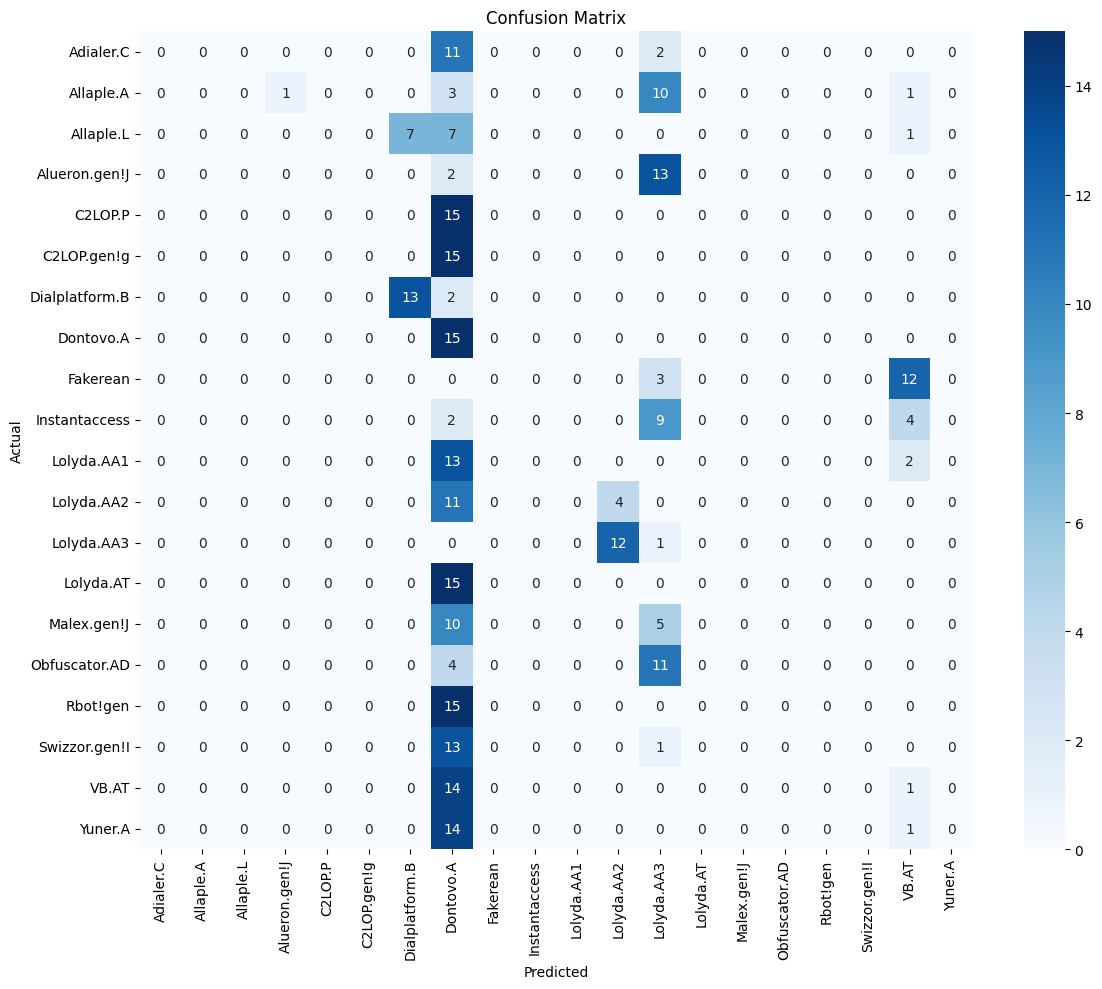

In [15]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define dataset path
DATASET_PATH = "/kaggle/working/output/patch_masked_50percent"

# Define image transformations for ViT
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.Resize((224, 224)),  # ViT requires a fixed input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1,1]
])

# Load datasets
train_dataset_50 = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "train"), transform=transform)
val_dataset_50 = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "val"), transform=transform)
test_dataset_50 = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "test"), transform=transform)

# Create DataLoaders
BATCH_SIZE = 32
train_loader_50 = DataLoader(train_dataset_50, batch_size=BATCH_SIZE, shuffle=True)
val_loader_50 = DataLoader(val_dataset_50, batch_size=BATCH_SIZE, shuffle=False)
test_loader_50 = DataLoader(test_dataset_50, batch_size=BATCH_SIZE, shuffle=False)


overall_acc, results_df = evaluate_vit_by_family(vit_model, test_loader_50, test_dataset_50,"/kaggle/working/50og.png")


In [16]:
import random
import torch
from torch.utils.data import DataLoader
import time
from tqdm import tqdm
import timm
import torch.nn as nn
import torch.optim as optim



SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

        
    


vit_model_50 = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(train_dataset_50.classes))

# # Move model to device
vit_model_50 = vit_model_50.to(device)

# # Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit_model_50.parameters(), lr=3e-4, weight_decay=1e-4)


# # Since we're using all classes, we don't need to filter the dataset
# # # # Just create DataLoaders directly from the full datasets
# BATCH_SIZE = 32
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# # Define device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # # Define loss function and optimizer
# # criterion = nn.CrossEntropyLoss()
# # optimizer = optim.AdamW(vit_model.parameters(), lr=3e-4, weight_decay=1e-4)

# # Print information about the training setup
print(f"✅ Training on all {len(train_dataset_50.classes)} malware families")
print(f"📊 Training samples: {len(train_dataset_50)}, Validation samples: {len(val_dataset_50)}")

train_vit_with_progress(vit_model_50, train_loader_50, val_loader_50, epochs=5, print_every=10)

# overall_acc, results_df, confusion_matrix = evaluate_vit_by_family(vit_model_25, test_loader_25, test_dataset_25)

✅ Training on all 20 malware families
📊 Training samples: 1995, Validation samples: 288

🚀 Epoch [1/5]


Training: 100%|██████████| 63/63 [01:15<00:00,  1.19s/it, acc=0.111, loss=2.93] 


📊 Epoch 1: Loss: 2.8802, Train Acc: 0.1213, Val Acc: 0.3021

🚀 Epoch [2/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.19s/it, acc=0.573, loss=1.16]


📊 Epoch 2: Loss: 1.1268, Train Acc: 0.5830, Val Acc: 0.6667

🚀 Epoch [3/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.19s/it, acc=0.844, loss=0.468]


📊 Epoch 3: Loss: 0.4660, Train Acc: 0.8451, Val Acc: 0.8993

🚀 Epoch [4/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.19s/it, acc=0.944, loss=0.164]


📊 Epoch 4: Loss: 0.1604, Train Acc: 0.9434, Val Acc: 0.9618

🚀 Epoch [5/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.19s/it, acc=0.944, loss=0.195]


📊 Epoch 5: Loss: 0.1986, Train Acc: 0.9434, Val Acc: 0.9271


In [17]:
# import os
# import torch
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader

# # Define dataset path
# DATASET_PATH = "/kaggle/working/output/patch_masked_75percent"

# # Define image transformations for ViT
# transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
#     transforms.Resize((224, 224)),  # ViT requires a fixed input size
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1,1]
# ])

# # Load datasets
# train_dataset_75 = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "train"), transform=transform)
# val_dataset_75 = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "val"), transform=transform)
# test_dataset_75 = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "test"), transform=transform)

# # Create DataLoaders
# BATCH_SIZE = 32
# train_loader_75 = DataLoader(train_dataset_75, batch_size=BATCH_SIZE, shuffle=True)
# val_loader_75 = DataLoader(val_dataset_75, batch_size=BATCH_SIZE, shuffle=False)
# test_loader_75 = DataLoader(test_dataset_75, batch_size=BATCH_SIZE, shuffle=False)


# overall_acc, results_df = evaluate_vit_by_family(vit_model, test_loader_75, test_dataset_75)


In [18]:
# import random
# import torch
# from torch.utils.data import DataLoader
# import time
# from tqdm import tqdm
# import timm
# import torch.nn as nn
# import torch.optim as optim






        
    


# vit_model_75 = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(train_dataset_75.classes))

# # # Move model to device
# vit_model_75 = vit_model_75.to(device)

# # # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(vit_model_75.parameters(), lr=3e-4, weight_decay=1e-4)


# # # Since we're using all classes, we don't need to filter the dataset
# # # # # Just create DataLoaders directly from the full datasets
# # BATCH_SIZE = 32
# # train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# # val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# # # Define device
# #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # # # Define loss function and optimizer
# # # criterion = nn.CrossEntropyLoss()
# # # optimizer = optim.AdamW(vit_model.parameters(), lr=3e-4, weight_decay=1e-4)

# # # Print information about the training setup
# print(f"✅ Training on all {len(train_dataset_75.classes)} malware families")
# print(f"📊 Training samples: {len(train_dataset_75)}, Validation samples: {len(val_dataset_75)}")

# train_vit_with_progress(vit_model_75, train_loader_75, val_loader_75, epochs=5, print_every=10)

# # overall_acc, results_df, confusion_matrix = evaluate_vit_by_family(vit_model_25, test_loader_25, test_dataset_25)

In [19]:
# #evaluating the classification ability of the models trained on 25, 50 and 75% masked images on
# #the 25% masked data
# print("25% masked data by model trained on 25% masked data")
# overall_acc, results_df = evaluate_vit_by_family(vit_model_25, test_loader_25, test_dataset_25)

# print("********************************************************")

# print("25% masked data by model trained on 50% masked data")
# overall_acc, results_df = evaluate_vit_by_family(vit_model_50, test_loader_25, test_dataset_25)

# print("********************************************************")

# print("25% masked data by model trained on 75% masked data")
# overall_acc, results_df = evaluate_vit_by_family(vit_model_75, test_loader_25, test_dataset_25)

********************************************************
50% masked data by model trained on 50% masked data

📊 Accuracy per family:
        Family  Accuracy  Precision   Recall  F1 Score
     Adialer.C  1.000000   1.000000 1.000000  1.000000
     Allaple.A  1.000000   1.000000 1.000000  1.000000
     Allaple.L  1.000000   1.000000 1.000000  1.000000
 Alueron.gen!J  1.000000   1.000000 1.000000  1.000000
Dialplatform.B  1.000000   1.000000 1.000000  1.000000
    Lolyda.AA2  1.000000   1.000000 1.000000  1.000000
    Lolyda.AA1  1.000000   1.000000 1.000000  1.000000
         VB.AT  1.000000   1.000000 1.000000  1.000000
      Rbot!gen  1.000000   1.000000 1.000000  1.000000
 Obfuscator.AD  1.000000   1.000000 1.000000  1.000000
   Malex.gen!J  1.000000   1.000000 1.000000  1.000000
    Lolyda.AA3  1.000000   1.000000 1.000000  1.000000
       Yuner.A  1.000000   1.000000 1.000000  1.000000
 Swizzor.gen!I  1.000000   1.000000 1.000000  1.000000
      Fakerean  0.933333   0.500000 0.4666

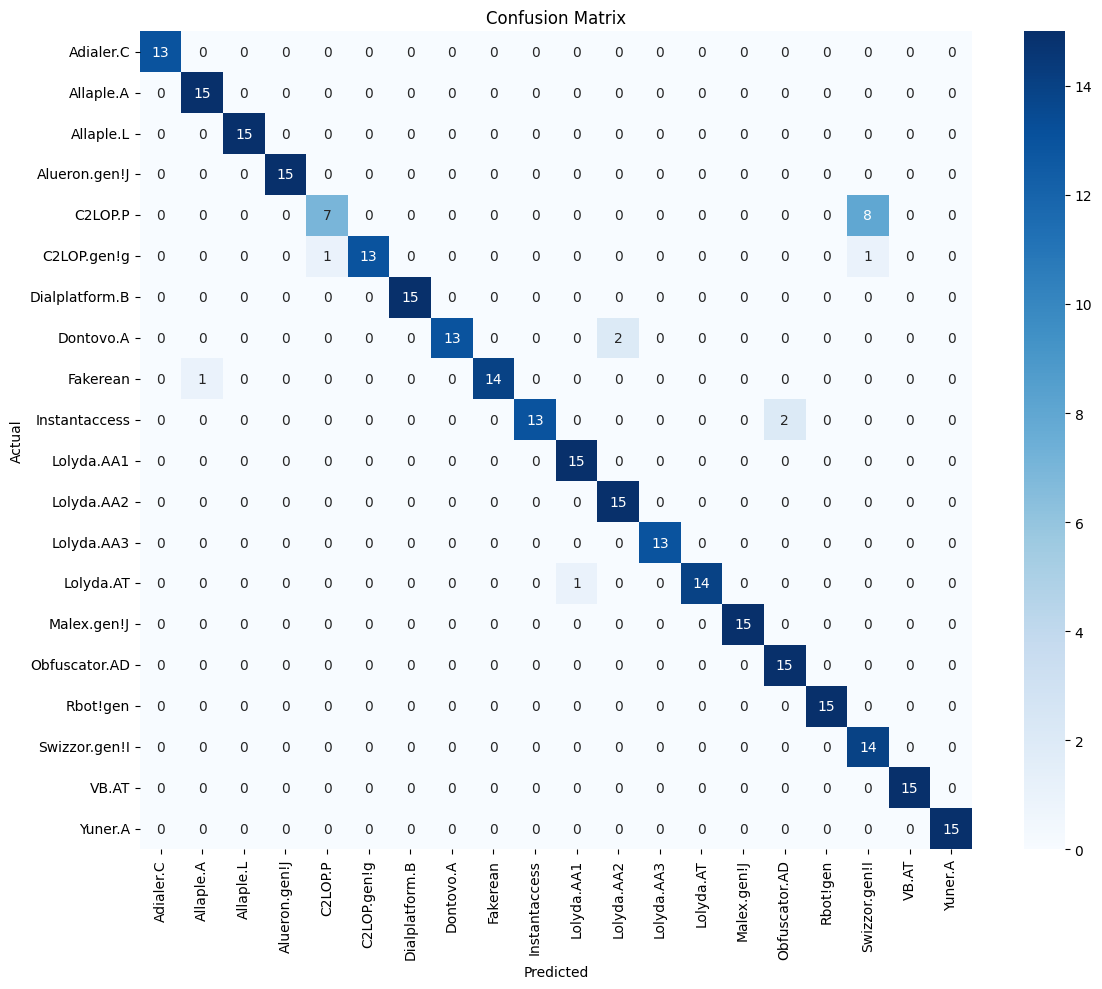

********************************************************


In [20]:
# #evaluating the classification ability of the models trained on 25, 50 and 75% masked images on
# #the 50% masked data
# print("50% masked data by model trained on 25% masked data")
# overall_acc, results_df = evaluate_vit_by_family(vit_model_25, test_loader_50, test_dataset_50)

print("********************************************************")

print("50% masked data by model trained on 50% masked data")
overall_acc, results_df = evaluate_vit_by_family(vit_model_50, test_loader_50, test_dataset_50,"/kaggle/working/5050.png")

print("********************************************************")

# print("50% masked data by model trained on 75% masked data")
# overall_acc, results_df = evaluate_vit_by_family(vit_model_75, test_loader_50, test_dataset_50)

In [21]:
# 9

In [22]:
from PIL import Image
import numpy as np
import os
from tqdm import tqdm

# --- Obfuscation Functions ---

def add_high_entropy_region(image, region='end', size_ratio=0.2):
    img = np.array(image)
    h, w = img.shape
    noise = np.random.randint(0, 256, (int(h * size_ratio), w), dtype=np.uint8)
    if region == 'end':
        img[-int(h * size_ratio):, :] = noise
    elif region == 'start':
        img[:int(h * size_ratio), :] = noise
    return Image.fromarray(img)

def insert_junk_block(image, position='middle', block_height=20):
    img = np.array(image)
    h, w = img.shape
    junk = np.tile(np.random.randint(0, 256), (block_height, w)).astype(np.uint8)
    if position == 'middle':
        mid = h // 2
        img[mid:mid+block_height, :] = junk
    return Image.fromarray(img)

def randomly_mask_patches(image, patch_size=16, mask_ratio=0.3):
    img = np.array(image)
    h, w = img.shape
    num_patches = (h // patch_size) * (w // patch_size)
    num_mask = int(mask_ratio * num_patches)
    
    masked_img = img.copy()
    patch_indices = list(np.ndindex(h // patch_size, w // patch_size))
    np.random.shuffle(patch_indices)
    
    for i, j in patch_indices[:num_mask]:
        masked_img[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = 0
    return Image.fromarray(masked_img)

def append_uniform_block(image, block_height_ratio=0.2, value=128):
    img = np.array(image)
    h, w = img.shape
    block_height = int(h * block_height_ratio)
    uniform_block = np.full((block_height, w), value, dtype=np.uint8)
    modified_img = np.vstack([img[:h - block_height], uniform_block])
    return Image.fromarray(modified_img)

def simulate_realistic_obfuscation(img):
    img = img.convert("L")
    img = add_high_entropy_region(img, 'start', 0.15)
    img = insert_junk_block(img)
    img = randomly_mask_patches(img, patch_size=16, mask_ratio=0.25)
    img = append_uniform_block(img, 0.1)
    return img

In [23]:
SOURCE_DIR = "/kaggle/working/filtered_malimg"
BASE_DEST_DIR = "/kaggle/working/obfuscated_malimg"

obfuscations = {
    "high_entropy": lambda img: add_high_entropy_region(img.convert("L"), 'start', 0.15),
    "junk_block": lambda img: insert_junk_block(img.convert("L")),
    "random_mask": lambda img: randomly_mask_patches(img.convert("L"), patch_size=16, mask_ratio=0.25),
    "uniform_block": lambda img: append_uniform_block(img.convert("L"), 0.1),
    "combined": simulate_realistic_obfuscation
}

splits = ['train', 'val', 'test']

# --- Obfuscation Processing ---
for obf_name, obf_func in obfuscations.items():
    print(f"\nApplying {obf_name} obfuscation...")
    dest_dir = os.path.join(BASE_DEST_DIR, obf_name)
    os.makedirs(dest_dir, exist_ok=True)
    
    for split in splits:
        split_path = os.path.join(SOURCE_DIR, split)
        for family in os.listdir(split_path):
            family_path = os.path.join(split_path, family)
            dest_family_path = os.path.join(dest_dir, split, family)
            os.makedirs(dest_family_path, exist_ok=True)
            
            for image_file in tqdm(os.listdir(family_path), desc=f"{obf_name} - {split}/{family}"):
                img_path = os.path.join(family_path, image_file)
                dest_path = os.path.join(dest_family_path, image_file)

                try:
                    img = Image.open(img_path)
                    obfuscated_img = obf_func(img)
                    obfuscated_img.save(dest_path)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")


Applying high_entropy obfuscation...


high_entropy - test/Lolyda.AA3: 100%|██████████| 13/13 [00:00<00:00, 158.94it/s]



Applying junk_block obfuscation...


junk_block - test/Lolyda.AA3: 100%|██████████| 13/13 [00:00<00:00, 207.80it/s]



Applying random_mask obfuscation...


random_mask - test/Lolyda.AA3: 100%|██████████| 13/13 [00:00<00:00, 188.09it/s]



Applying uniform_block obfuscation...


uniform_block - test/Lolyda.AA3: 100%|██████████| 13/13 [00:00<00:00, 254.82it/s]



Applying combined obfuscation...


combined - test/Lolyda.AA3: 100%|██████████| 13/13 [00:00<00:00, 161.76it/s]


In [24]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define dataset path
DATASET_PATH = "/kaggle/working/obfuscated_malimg/high_entropy"

# Define image transformations for ViT
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.Resize((224, 224)),  # ViT requires a fixed input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1,1]
])

# Load datasets
obhe_train_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "train"), transform=transform)
obhe_val_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "val"), transform=transform)
obhe_test_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "test"), transform=transform)

# Create DataLoaders
BATCH_SIZE = 32
obhe_train_loader = DataLoader(obhe_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
obhe_val_loader = DataLoader(obhe_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
obhe_test_loader = DataLoader(obhe_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check dataset details
print(f"Training samples: {len(obhe_train_dataset)}")
print(f"Validation samples: {len(obhe_val_dataset)}")
print(f"Testing samples: {len(obhe_test_dataset)}")
print(f"Classes: {obhe_train_dataset.classes}")

Training samples: 1995
Validation samples: 288
Testing samples: 295
Classes: ['Adialer.C', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Swizzor.gen!I', 'VB.AT', 'Yuner.A']


In [25]:
import timm
import torch.nn as nn
import torch.optim as optim

# Load a pretrained Vision Transformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model_obhe = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(obhe_train_dataset.classes))

# Move model to device
vit_model_obhe = vit_model_obhe.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit_model_obhe.parameters(), lr=3e-4, weight_decay=1e-4)

In [26]:
import random
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # For better progress visualization

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# # Since we're using all classes, we don't need to filter the dataset
# # Just create DataLoaders directly from the full datasets
# BATCH_SIZE = 32
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# # Define device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(vit_model.parameters(), lr=3e-4, weight_decay=1e-4)

# Print information about the training setup
print(f"✅ Training on all {len(obhe_train_dataset.classes)} malware families")
print(f"📊 Training samples: {len(obhe_train_dataset)}, Validation samples: {len(obhe_val_dataset)}")

# Training function with progress tracking
def train_vit_with_progress(model, train_loader, val_loader, epochs=5, print_every=10):
    model.train()
    
    for epoch in range(epochs):
        print(f"\n🚀 Epoch [{epoch+1}/{epochs}]")
        total_loss = 0
        correct, total = 0, 0
        
        # Use tqdm for progress tracking
        batch_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")
        for batch_idx, (images, labels) in batch_iterator:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            # Print progress every N batches
            if (batch_idx + 1) % print_every == 0:
                batch_acc = correct / total
                batch_iterator.set_postfix(loss=total_loss / (batch_idx + 1), acc=batch_acc)
        # Compute training and validation accuracy
        train_acc = correct / total
        val_acc = evaluate_vit(model, val_loader)
        print(f"📊 Epoch {epoch+1}: Loss: {total_loss / len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Validation function
def evaluate_vit(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Train ViT with Progress Tracking
train_vit_with_progress(vit_model_obhe, obhe_train_loader, obhe_val_loader, epochs=5, print_every=10)





✅ Training on all 20 malware families
📊 Training samples: 1995, Validation samples: 288

🚀 Epoch [1/5]


Training: 100%|██████████| 63/63 [01:13<00:00,  1.17s/it, acc=0.368, loss=1.99] 


📊 Epoch 1: Loss: 1.9234, Train Acc: 0.3850, Val Acc: 0.8090

🚀 Epoch [2/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.19s/it, acc=0.854, loss=0.48] 


📊 Epoch 2: Loss: 0.4665, Train Acc: 0.8556, Val Acc: 0.8611

🚀 Epoch [3/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.19s/it, acc=0.915, loss=0.254]


📊 Epoch 3: Loss: 0.2521, Train Acc: 0.9143, Val Acc: 0.9306

🚀 Epoch [4/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.19s/it, acc=0.945, loss=0.162]


📊 Epoch 4: Loss: 0.1716, Train Acc: 0.9449, Val Acc: 0.9653

🚀 Epoch [5/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.19s/it, acc=0.969, loss=0.0921]


📊 Epoch 5: Loss: 0.0933, Train Acc: 0.9689, Val Acc: 0.9340



📊 Accuracy per family:
        Family  Accuracy  Precision   Recall  F1 Score
     Adialer.C  1.000000   1.000000 1.000000  1.000000
     Allaple.L  1.000000   1.000000 1.000000  1.000000
 Alueron.gen!J  1.000000   1.000000 1.000000  1.000000
       C2LOP.P  1.000000   1.000000 1.000000  1.000000
      Rbot!gen  1.000000   1.000000 1.000000  1.000000
Dialplatform.B  1.000000   1.000000 1.000000  1.000000
     Dontovo.A  1.000000   1.000000 1.000000  1.000000
 Instantaccess  1.000000   1.000000 1.000000  1.000000
    Lolyda.AA2  1.000000   1.000000 1.000000  1.000000
    Lolyda.AA1  1.000000   1.000000 1.000000  1.000000
     Lolyda.AT  1.000000   1.000000 1.000000  1.000000
    Lolyda.AA3  1.000000   1.000000 1.000000  1.000000
       Yuner.A  1.000000   1.000000 1.000000  1.000000
         VB.AT  1.000000   1.000000 1.000000  1.000000
   Malex.gen!J  1.000000   1.000000 1.000000  1.000000
 Obfuscator.AD  1.000000   1.000000 1.000000  1.000000
      Fakerean  0.933333   0.500000 0.466

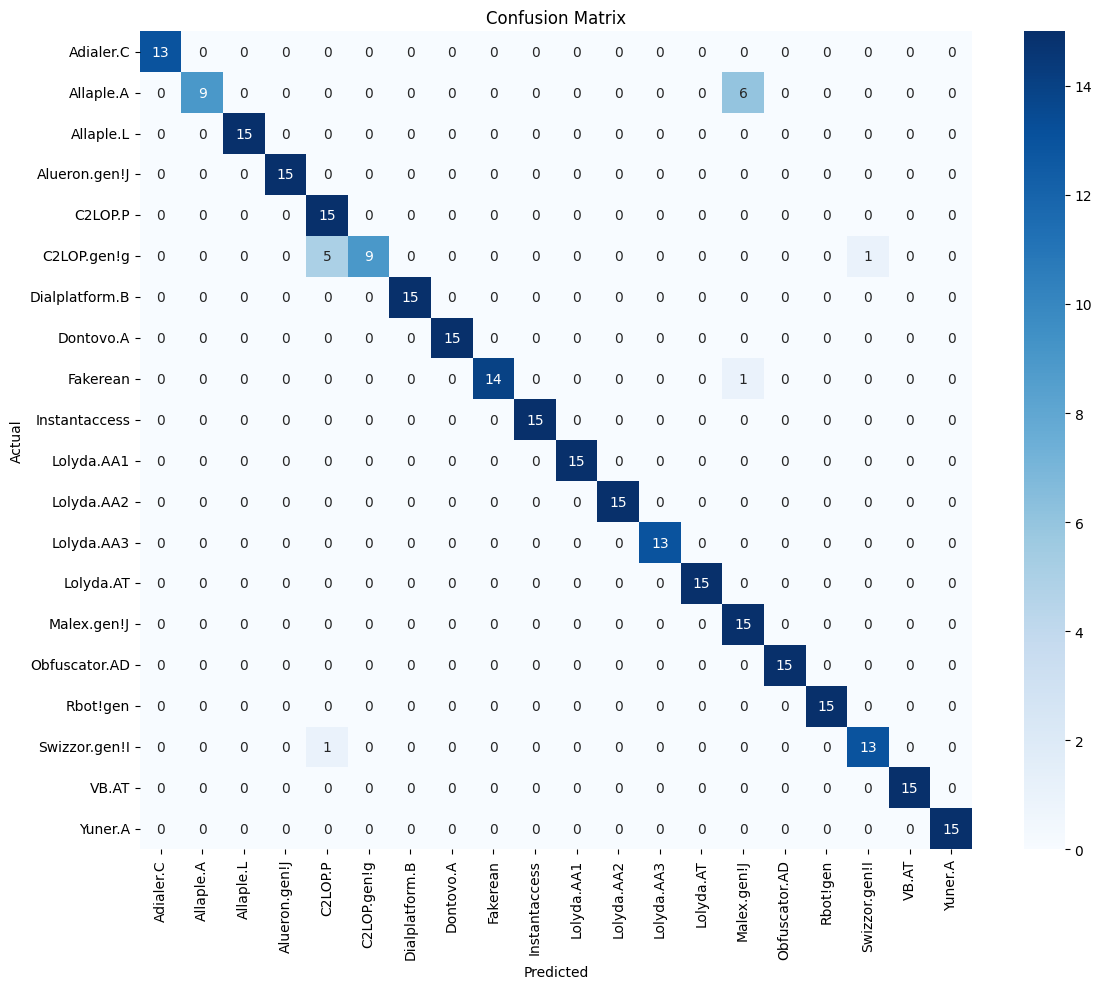

In [27]:
overall_acc, results_df = evaluate_vit_by_family(vit_model_obhe, obhe_test_loader, obhe_test_dataset,"/kaggle/working/hehe.png")


📊 Accuracy per family:
        Family  Accuracy  Precision   Recall  F1 Score
     Allaple.A  1.000000   1.000000 1.000000  1.000000
     Allaple.L  1.000000   1.000000 1.000000  1.000000
 Alueron.gen!J  1.000000   1.000000 1.000000  1.000000
   C2LOP.gen!g  1.000000   1.000000 1.000000  1.000000
       Yuner.A  1.000000   1.000000 1.000000  1.000000
Dialplatform.B  1.000000   1.000000 1.000000  1.000000
 Instantaccess  1.000000   1.000000 1.000000  1.000000
      Fakerean  1.000000   1.000000 1.000000  1.000000
    Lolyda.AA1  1.000000   1.000000 1.000000  1.000000
    Lolyda.AA2  1.000000   1.000000 1.000000  1.000000
     Lolyda.AT  1.000000   1.000000 1.000000  1.000000
    Lolyda.AA3  1.000000   1.000000 1.000000  1.000000
 Swizzor.gen!I  1.000000   1.000000 1.000000  1.000000
       C2LOP.P  0.933333   0.500000 0.466667  0.482759
         VB.AT  0.666667   0.333333 0.222222  0.266667
     Dontovo.A  0.333333   0.500000 0.166667  0.250000
      Rbot!gen  0.133333   0.500000 0.066

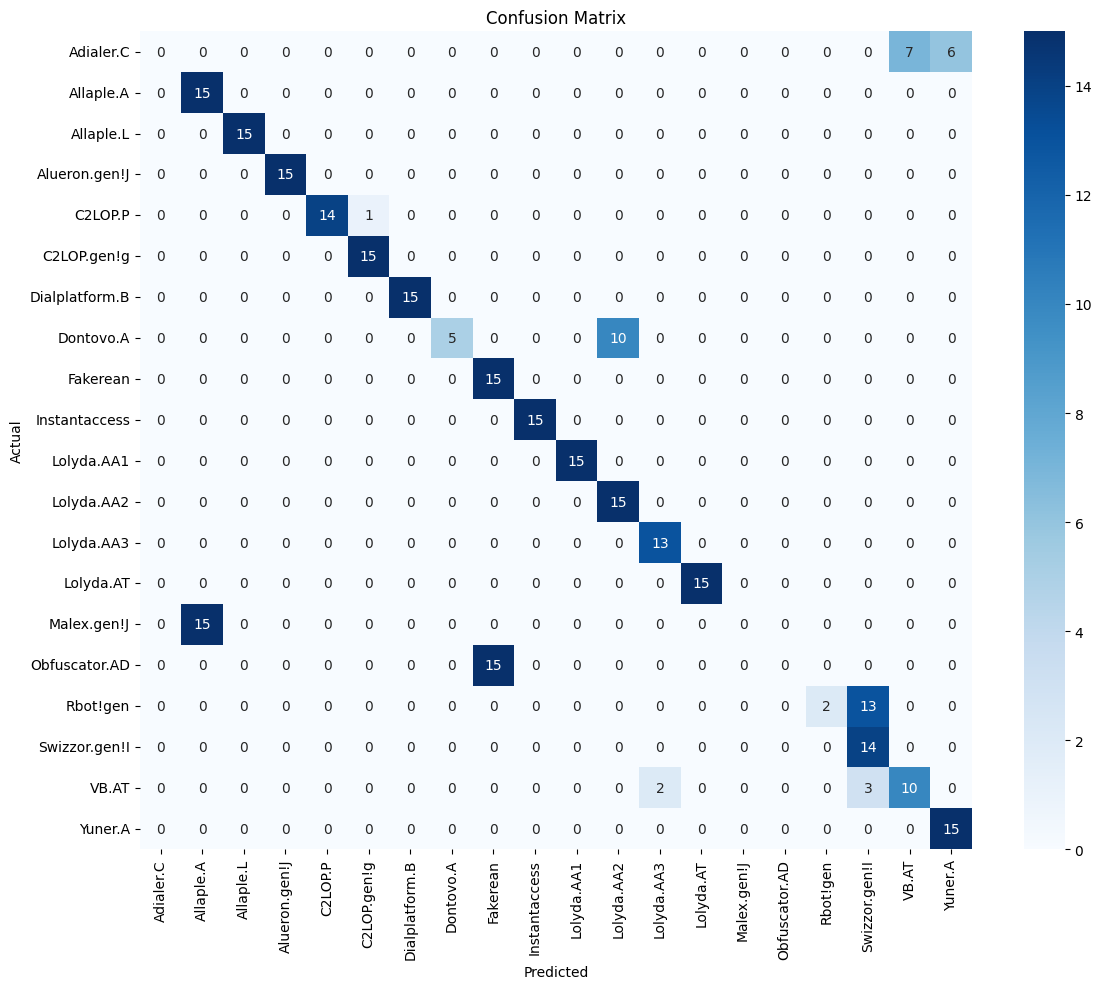

In [28]:
overall_acc, results_df = evaluate_vit_by_family(vit_model, obhe_test_loader, obhe_test_dataset,"/kaggle/working/heog.png")

In [29]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define dataset path
DATASET_PATH = "/kaggle/working/obfuscated_malimg/junk_block"

# Define image transformations for ViT
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.Resize((224, 224)),  # ViT requires a fixed input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1,1]
])

# Load datasets
objb_train_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "train"), transform=transform)
objb_val_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "val"), transform=transform)
objb_test_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "test"), transform=transform)

# Create DataLoaders
BATCH_SIZE = 32
objb_train_loader = DataLoader(objb_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
objb_val_loader = DataLoader(objb_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
objb_test_loader = DataLoader(objb_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check dataset details
print(f"Training samples: {len(objb_train_dataset)}")
print(f"Validation samples: {len(objb_val_dataset)}")
print(f"Testing samples: {len(objb_test_dataset)}")
print(f"Classes: {objb_train_dataset.classes}")

Training samples: 1995
Validation samples: 288
Testing samples: 295
Classes: ['Adialer.C', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Swizzor.gen!I', 'VB.AT', 'Yuner.A']


In [30]:
import timm
import torch.nn as nn
import torch.optim as optim

# Load a pretrained Vision Transformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model_objb = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(objb_train_dataset.classes))

# Move model to device
vit_model_objb = vit_model_objb.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit_model_objb.parameters(), lr=3e-4, weight_decay=1e-4)

In [31]:
import random
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # For better progress visualization

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# # Since we're using all classes, we don't need to filter the dataset
# # Just create DataLoaders directly from the full datasets
# BATCH_SIZE = 32
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# # Define device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(vit_model.parameters(), lr=3e-4, weight_decay=1e-4)

# Print information about the training setup
print(f"✅ Training on all {len(objb_train_dataset.classes)} malware families")
print(f"📊 Training samples: {len(objb_train_dataset)}, Validation samples: {len(objb_val_dataset)}")

# Training function with progress tracking
def train_vit_with_progress(model, train_loader, val_loader, epochs=5, print_every=10):
    model.train()
    
    for epoch in range(epochs):
        print(f"\n🚀 Epoch [{epoch+1}/{epochs}]")
        total_loss = 0
        correct, total = 0, 0
        
        # Use tqdm for progress tracking
        batch_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")
        for batch_idx, (images, labels) in batch_iterator:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            # Print progress every N batches
            if (batch_idx + 1) % print_every == 0:
                batch_acc = correct / total
                batch_iterator.set_postfix(loss=total_loss / (batch_idx + 1), acc=batch_acc)
        # Compute training and validation accuracy
        train_acc = correct / total
        val_acc = evaluate_vit(model, val_loader)
        print(f"📊 Epoch {epoch+1}: Loss: {total_loss / len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Validation function
def evaluate_vit(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Train ViT with Progress Tracking
train_vit_with_progress(vit_model_objb, objb_train_loader, objb_val_loader, epochs=5, print_every=10)

✅ Training on all 20 malware families
📊 Training samples: 1995, Validation samples: 288

🚀 Epoch [1/5]


Training: 100%|██████████| 63/63 [01:15<00:00,  1.19s/it, acc=0.349, loss=2.07] 


📊 Epoch 1: Loss: 2.0283, Train Acc: 0.3649, Val Acc: 0.8403

🚀 Epoch [2/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.19s/it, acc=0.896, loss=0.34] 


📊 Epoch 2: Loss: 0.3437, Train Acc: 0.8992, Val Acc: 0.9688

🚀 Epoch [3/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.19s/it, acc=0.952, loss=0.157]


📊 Epoch 3: Loss: 0.1513, Train Acc: 0.9534, Val Acc: 0.9792

🚀 Epoch [4/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.18s/it, acc=0.979, loss=0.0656]


📊 Epoch 4: Loss: 0.0794, Train Acc: 0.9779, Val Acc: 0.9375

🚀 Epoch [5/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.19s/it, acc=0.97, loss=0.0939]


📊 Epoch 5: Loss: 0.0906, Train Acc: 0.9709, Val Acc: 0.9653



📊 Accuracy per family:
        Family  Accuracy  Precision   Recall  F1 Score
     Adialer.C  1.000000   1.000000 1.000000  1.000000
     Allaple.L  1.000000   1.000000 1.000000  1.000000
 Alueron.gen!J  1.000000   1.000000 1.000000  1.000000
     Dontovo.A  1.000000   1.000000 1.000000  1.000000
      Rbot!gen  1.000000   1.000000 1.000000  1.000000
Dialplatform.B  1.000000   1.000000 1.000000  1.000000
 Instantaccess  1.000000   1.000000 1.000000  1.000000
      Fakerean  1.000000   1.000000 1.000000  1.000000
    Lolyda.AA1  1.000000   1.000000 1.000000  1.000000
    Lolyda.AA2  1.000000   1.000000 1.000000  1.000000
     Lolyda.AT  1.000000   1.000000 1.000000  1.000000
    Lolyda.AA3  1.000000   1.000000 1.000000  1.000000
       Yuner.A  1.000000   1.000000 1.000000  1.000000
 Swizzor.gen!I  1.000000   1.000000 1.000000  1.000000
   Malex.gen!J  1.000000   1.000000 1.000000  1.000000
 Obfuscator.AD  1.000000   1.000000 1.000000  1.000000
     Allaple.A  0.933333   0.500000 0.466

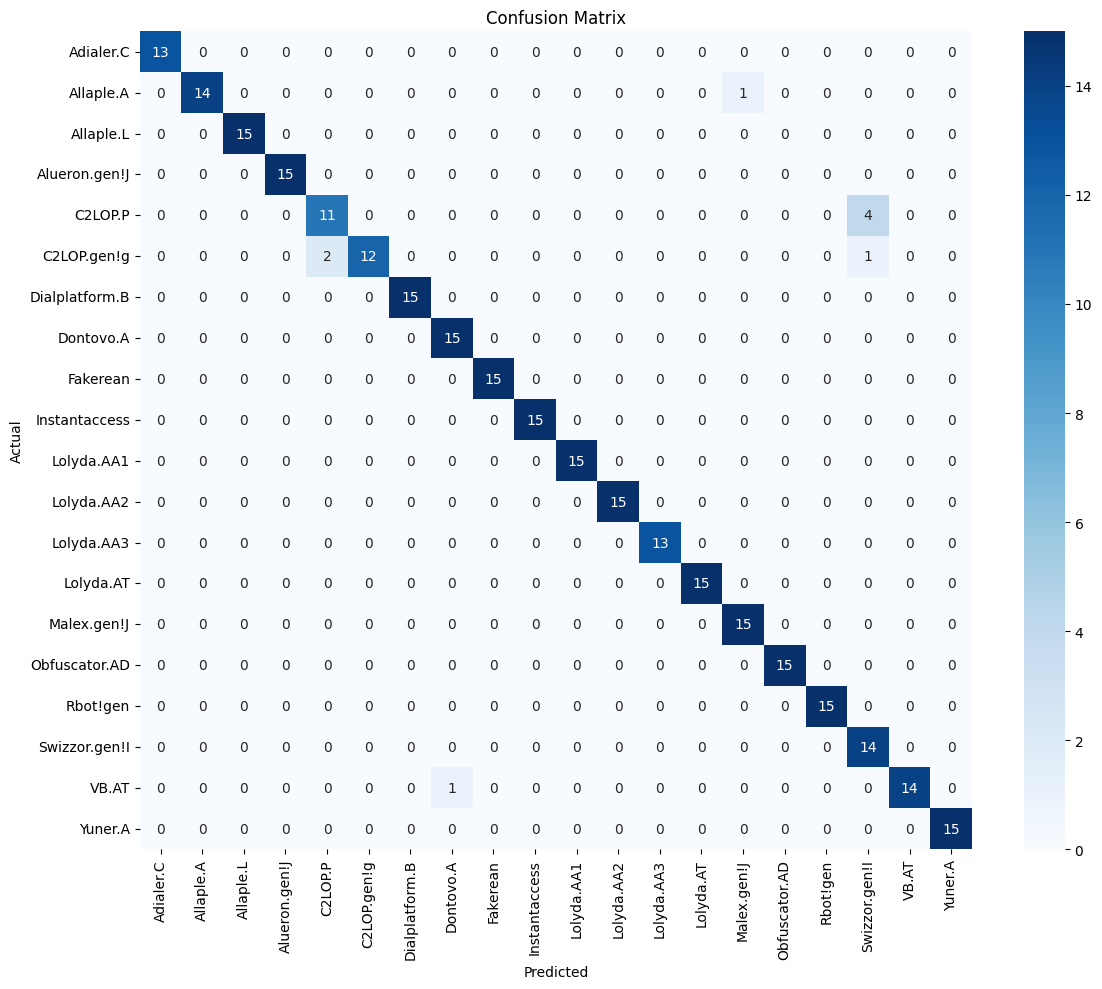


📊 Accuracy per family:
        Family  Accuracy  Precision   Recall  F1 Score
     Adialer.C  1.000000   1.000000 1.000000  1.000000
     Allaple.L  1.000000   1.000000 1.000000  1.000000
    Lolyda.AA1  1.000000   1.000000 1.000000  1.000000
Dialplatform.B  1.000000   1.000000 1.000000  1.000000
    Lolyda.AA2  1.000000   1.000000 1.000000  1.000000
       Yuner.A  1.000000   1.000000 1.000000  1.000000
 Instantaccess  1.000000   1.000000 1.000000  1.000000
      Fakerean  1.000000   1.000000 1.000000  1.000000
   Malex.gen!J  1.000000   1.000000 1.000000  1.000000
    Lolyda.AA3  1.000000   1.000000 1.000000  1.000000
 Obfuscator.AD  0.933333   0.500000 0.466667  0.482759
 Alueron.gen!J  0.933333   0.500000 0.466667  0.482759
         VB.AT  0.933333   0.500000 0.466667  0.482759
      Rbot!gen  0.933333   0.500000 0.466667  0.482759
   C2LOP.gen!g  0.933333   0.500000 0.466667  0.482759
     Lolyda.AT  0.933333   0.500000 0.466667  0.482759
       C2LOP.P  0.866667   0.333333 0.288

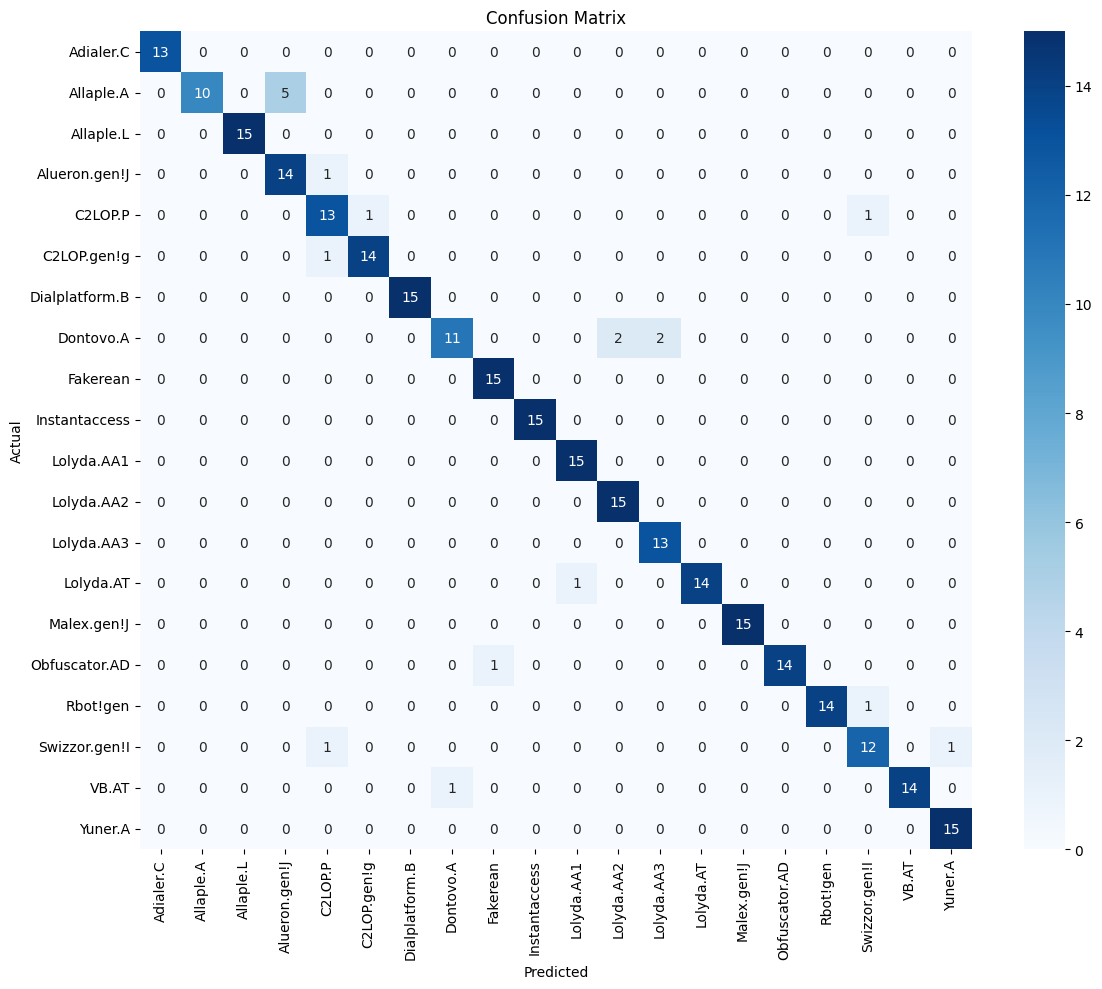

In [32]:
overall_acc, results_df = evaluate_vit_by_family(vit_model_objb, objb_test_loader, objb_test_dataset,"/kaggle/working/jbjb.png")
overall_acc, results_df = evaluate_vit_by_family(vit_model, objb_test_loader, objb_test_dataset,"/kaggle/working/jbog.png")

In [33]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define dataset path
DATASET_PATH = "/kaggle/working/obfuscated_malimg/random_mask"

# Define image transformations for ViT
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.Resize((224, 224)),  # ViT requires a fixed input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1,1]
])

# Load datasets
obrm_train_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "train"), transform=transform)
obrm_val_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "val"), transform=transform)
obrm_test_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "test"), transform=transform)

# Create DataLoaders
BATCH_SIZE = 32
obrm_train_loader = DataLoader(obrm_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
obrm_val_loader = DataLoader(obrm_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
obrm_test_loader = DataLoader(obrm_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check dataset details
print(f"Training samples: {len(obrm_train_dataset)}")
print(f"Validation samples: {len(obrm_val_dataset)}")
print(f"Testing samples: {len(obrm_test_dataset)}")
print(f"Classes: {obrm_train_dataset.classes}")

Training samples: 1995
Validation samples: 288
Testing samples: 295
Classes: ['Adialer.C', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Swizzor.gen!I', 'VB.AT', 'Yuner.A']


In [34]:
import timm
import torch.nn as nn
import torch.optim as optim

# Load a pretrained Vision Transformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model_obrm = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(obrm_train_dataset.classes))

# Move model to device
vit_model_obrm = vit_model_obrm.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit_model_obrm.parameters(), lr=3e-4, weight_decay=1e-4)

In [35]:
import random
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # For better progress visualization

SEED = 20
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# # Since we're using all classes, we don't need to filter the dataset
# # Just create DataLoaders directly from the full datasets
# BATCH_SIZE = 32
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# # Define device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(vit_model.parameters(), lr=3e-4, weight_decay=1e-4)

# Print information about the training setup
print(f"✅ Training on all {len(obrm_train_dataset.classes)} malware families")
print(f"📊 Training samples: {len(obrm_train_dataset)}, Validation samples: {len(obrm_val_dataset)}")

# Training function with progress tracking
def train_vit_with_progress(model, train_loader, val_loader, epochs=5, print_every=10):
    model.train()
    
    for epoch in range(epochs):
        print(f"\n🚀 Epoch [{epoch+1}/{epochs}]")
        total_loss = 0
        correct, total = 0, 0
        
        # Use tqdm for progress tracking
        batch_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")
        for batch_idx, (images, labels) in batch_iterator:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            # Print progress every N batches
            if (batch_idx + 1) % print_every == 0:
                batch_acc = correct / total
                batch_iterator.set_postfix(loss=total_loss / (batch_idx + 1), acc=batch_acc)
        # Compute training and validation accuracy
        train_acc = correct / total
        val_acc = evaluate_vit(model, val_loader)
        print(f"📊 Epoch {epoch+1}: Loss: {total_loss / len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Validation function
def evaluate_vit(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Train ViT with Progress Tracking
train_vit_with_progress(vit_model_obrm, obrm_train_loader, obrm_val_loader, epochs=5, print_every=10)

✅ Training on all 20 malware families
📊 Training samples: 1995, Validation samples: 288

🚀 Epoch [1/5]


Training: 100%|██████████| 63/63 [01:15<00:00,  1.19s/it, acc=0.35, loss=2.03]  


📊 Epoch 1: Loss: 1.9679, Train Acc: 0.3649, Val Acc: 0.6181

🚀 Epoch [2/5]


Training: 100%|██████████| 63/63 [01:15<00:00,  1.19s/it, acc=0.816, loss=0.519]


📊 Epoch 2: Loss: 0.5205, Train Acc: 0.8175, Val Acc: 0.8438

🚀 Epoch [3/5]


Training: 100%|██████████| 63/63 [01:15<00:00,  1.19s/it, acc=0.906, loss=0.239]


📊 Epoch 3: Loss: 0.2341, Train Acc: 0.9073, Val Acc: 0.9583

🚀 Epoch [4/5]


Training: 100%|██████████| 63/63 [01:15<00:00,  1.19s/it, acc=0.966, loss=0.116] 


📊 Epoch 4: Loss: 0.1135, Train Acc: 0.9654, Val Acc: 0.9618

🚀 Epoch [5/5]


Training: 100%|██████████| 63/63 [01:15<00:00,  1.19s/it, acc=0.949, loss=0.177] 


📊 Epoch 5: Loss: 0.1722, Train Acc: 0.9499, Val Acc: 0.9444



📊 Accuracy per family:
        Family  Accuracy  Precision   Recall  F1 Score
     Adialer.C  1.000000        1.0 1.000000  1.000000
     Allaple.A  1.000000        1.0 1.000000  1.000000
     Allaple.L  1.000000        1.0 1.000000  1.000000
 Alueron.gen!J  1.000000        1.0 1.000000  1.000000
       C2LOP.P  1.000000        1.0 1.000000  1.000000
Dialplatform.B  1.000000        1.0 1.000000  1.000000
     Dontovo.A  1.000000        1.0 1.000000  1.000000
 Instantaccess  1.000000        1.0 1.000000  1.000000
    Lolyda.AA2  1.000000        1.0 1.000000  1.000000
    Lolyda.AA1  1.000000        1.0 1.000000  1.000000
 Obfuscator.AD  1.000000        1.0 1.000000  1.000000
    Lolyda.AA3  1.000000        1.0 1.000000  1.000000
       Yuner.A  1.000000        1.0 1.000000  1.000000
      Rbot!gen  1.000000        1.0 1.000000  1.000000
         VB.AT  0.933333        0.5 0.466667  0.482759
      Fakerean  0.933333        0.5 0.466667  0.482759
   Malex.gen!J  0.866667        0.5 0.433

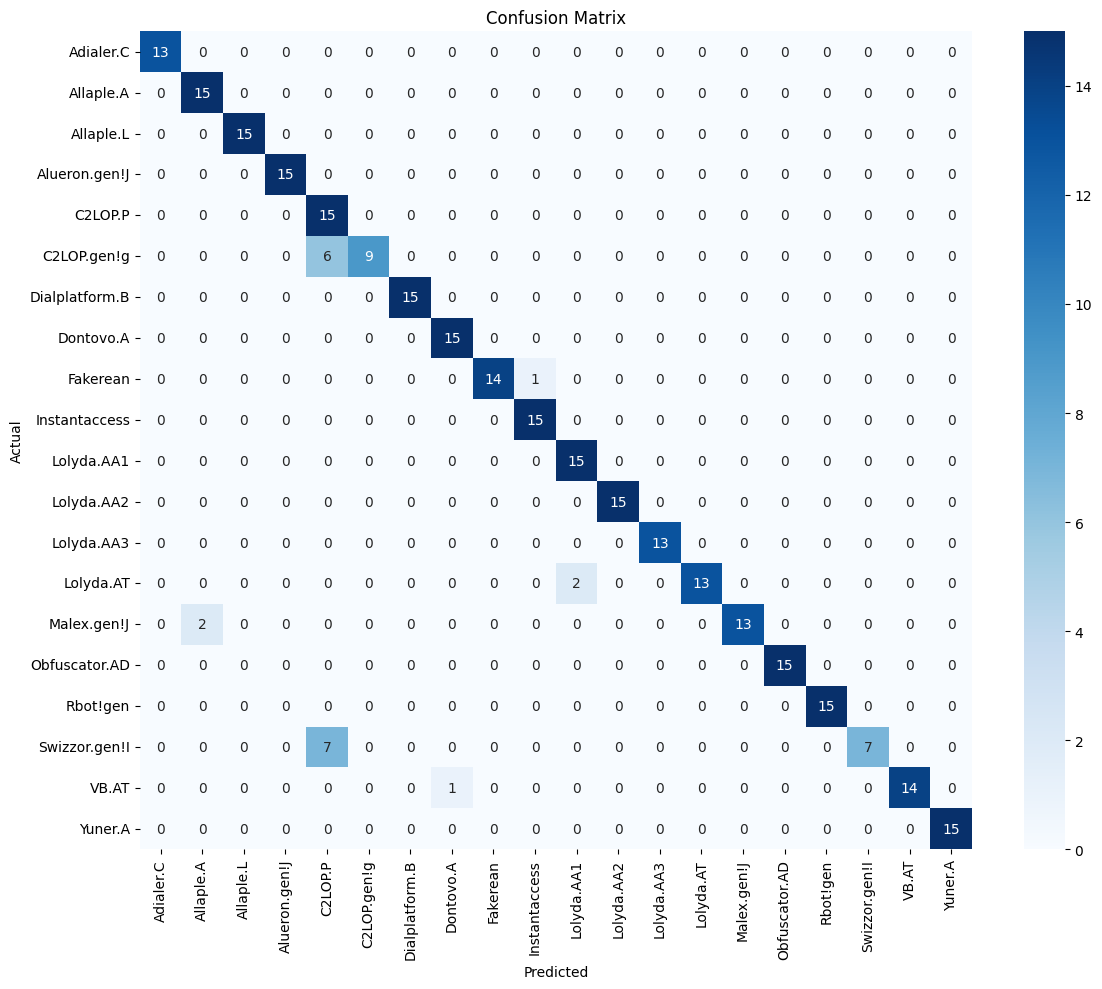


📊 Accuracy per family:
        Family  Accuracy  Precision   Recall  F1 Score
    Lolyda.AA2  1.000000   1.000000 1.000000  1.000000
    Lolyda.AA1  1.000000   1.000000 1.000000  1.000000
Dialplatform.B  1.000000   1.000000 1.000000  1.000000
     Dontovo.A  1.000000   1.000000 1.000000  1.000000
    Lolyda.AA3  1.000000   1.000000 1.000000  1.000000
     Lolyda.AT  0.933333   0.500000 0.466667  0.482759
 Swizzor.gen!I  0.785714   0.250000 0.196429  0.220000
     Adialer.C  0.769231   0.333333 0.256410  0.289855
   Malex.gen!J  0.733333   0.333333 0.244444  0.282051
 Alueron.gen!J  0.666667   0.333333 0.222222  0.266667
         VB.AT  0.400000   0.500000 0.200000  0.285714
     Allaple.L  0.066667   0.333333 0.022222  0.041667
      Fakerean  0.066667   0.333333 0.022222  0.041667
      Rbot!gen  0.066667   0.200000 0.013333  0.025000
     Allaple.A  0.000000   0.000000 0.000000  0.000000
   C2LOP.gen!g  0.000000   0.000000 0.000000  0.000000
 Instantaccess  0.000000   0.000000 0.000

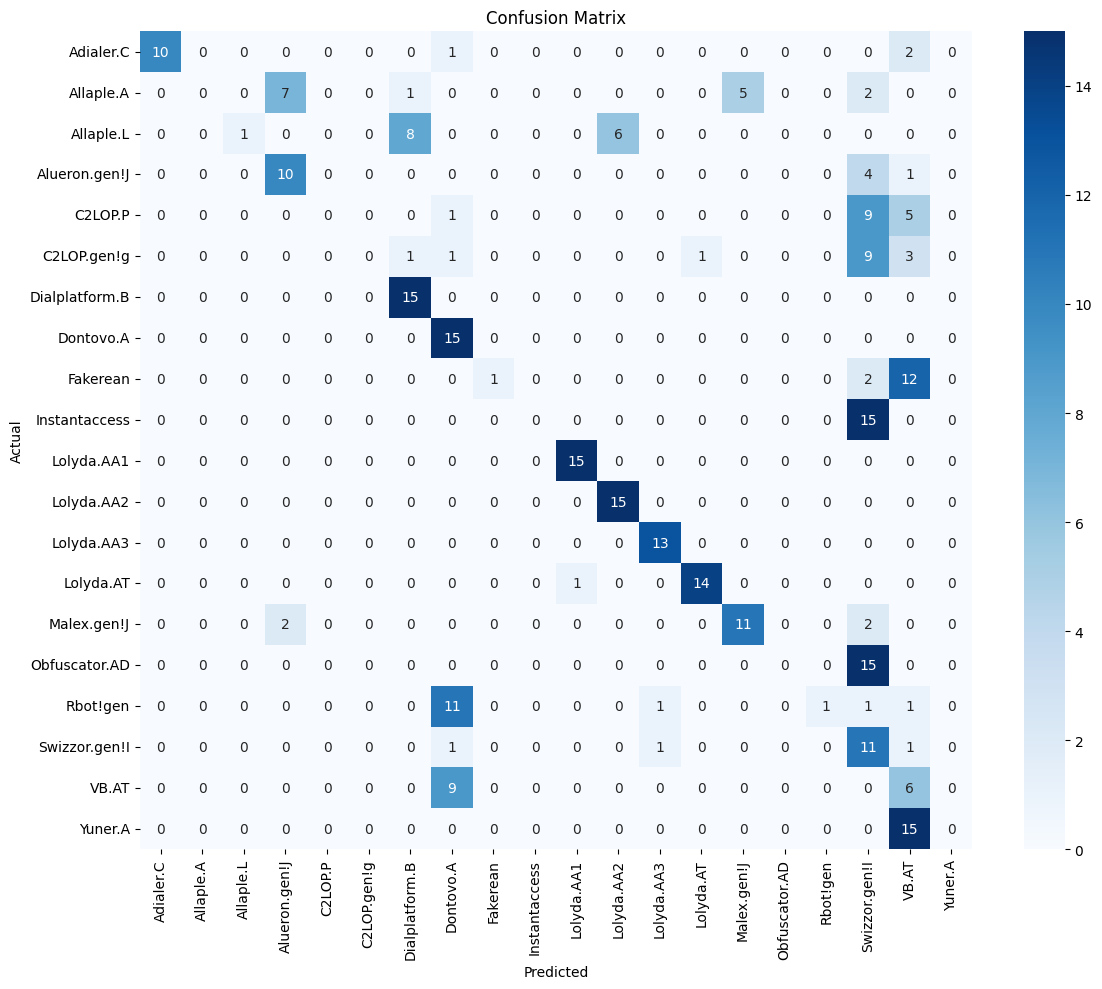

In [36]:
overall_acc, results_df = evaluate_vit_by_family(vit_model_obrm, obrm_test_loader, obrm_test_dataset,"/kaggle/working/rmrm.png")
overall_acc, results_df = evaluate_vit_by_family(vit_model, obrm_test_loader, obrm_test_dataset,"/kaggle/working/rmog.png")

In [37]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define dataset path
DATASET_PATH = "/kaggle/working/obfuscated_malimg/uniform_block"

# Define image transformations for ViT
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.Resize((224, 224)),  # ViT requires a fixed input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1,1]
])

# Load datasets
obub_train_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "train"), transform=transform)
obub_val_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "val"), transform=transform)
obub_test_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "test"), transform=transform)

# Create DataLoaders
BATCH_SIZE = 32
obub_train_loader = DataLoader(obub_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
obub_val_loader = DataLoader(obub_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
obub_test_loader = DataLoader(obub_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check dataset details
print(f"Training samples: {len(obub_train_dataset)}")
print(f"Validation samples: {len(obub_val_dataset)}")
print(f"Testing samples: {len(obub_test_dataset)}")
print(f"Classes: {obub_train_dataset.classes}")

Training samples: 1995
Validation samples: 288
Testing samples: 295
Classes: ['Adialer.C', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Swizzor.gen!I', 'VB.AT', 'Yuner.A']


In [38]:
import timm
import torch.nn as nn
import torch.optim as optim

# Load a pretrained Vision Transformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model_obub = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(obub_train_dataset.classes))

# Move model to device
vit_model_obub = vit_model_obub.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit_model_obub.parameters(), lr=3e-4, weight_decay=1e-4)

In [39]:
import random
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # For better progress visualization

SEED = 2
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# # Since we're using all classes, we don't need to filter the dataset
# # Just create DataLoaders directly from the full datasets
# BATCH_SIZE = 32
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# # Define device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(vit_model.parameters(), lr=3e-4, weight_decay=1e-4)

# Print information about the training setup
print(f"✅ Training on all {len(obub_train_dataset.classes)} malware families")
print(f"📊 Training samples: {len(obub_train_dataset)}, Validation samples: {len(obub_val_dataset)}")

# Training function with progress tracking
def train_vit_with_progress(model, train_loader, val_loader, epochs=5, print_every=10):
    model.train()
    
    for epoch in range(epochs):
        print(f"\n🚀 Epoch [{epoch+1}/{epochs}]")
        total_loss = 0
        correct, total = 0, 0
        
        # Use tqdm for progress tracking
        batch_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")
        for batch_idx, (images, labels) in batch_iterator:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            # Print progress every N batches
            if (batch_idx + 1) % print_every == 0:
                batch_acc = correct / total
                batch_iterator.set_postfix(loss=total_loss / (batch_idx + 1), acc=batch_acc)
        # Compute training and validation accuracy
        train_acc = correct / total
        val_acc = evaluate_vit(model, val_loader)
        print(f"📊 Epoch {epoch+1}: Loss: {total_loss / len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Validation function
def evaluate_vit(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Train ViT with Progress Tracking
train_vit_with_progress(vit_model_obub, obub_train_loader, obub_val_loader, epochs=5, print_every=10)

✅ Training on all 20 malware families
📊 Training samples: 1995, Validation samples: 288

🚀 Epoch [1/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.19s/it, acc=0.369, loss=1.93]


📊 Epoch 1: Loss: 1.8837, Train Acc: 0.3810, Val Acc: 0.7083

🚀 Epoch [2/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.18s/it, acc=0.79, loss=0.571] 


📊 Epoch 2: Loss: 0.5687, Train Acc: 0.7940, Val Acc: 0.8229

🚀 Epoch [3/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.18s/it, acc=0.913, loss=0.267]


📊 Epoch 3: Loss: 0.2593, Train Acc: 0.9153, Val Acc: 0.9514

🚀 Epoch [4/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.19s/it, acc=0.94, loss=0.183] 


📊 Epoch 4: Loss: 0.1890, Train Acc: 0.9409, Val Acc: 0.9062

🚀 Epoch [5/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.18s/it, acc=0.934, loss=0.21] 


📊 Epoch 5: Loss: 0.2068, Train Acc: 0.9358, Val Acc: 0.9514



📊 Accuracy per family:
        Family  Accuracy  Precision   Recall  F1 Score
     Adialer.C  1.000000        1.0 1.000000  1.000000
     Allaple.A  1.000000        1.0 1.000000  1.000000
     Allaple.L  1.000000        1.0 1.000000  1.000000
 Alueron.gen!J  1.000000        1.0 1.000000  1.000000
     Dontovo.A  1.000000        1.0 1.000000  1.000000
Dialplatform.B  1.000000        1.0 1.000000  1.000000
    Lolyda.AA1  1.000000        1.0 1.000000  1.000000
 Instantaccess  1.000000        1.0 1.000000  1.000000
    Lolyda.AA2  1.000000        1.0 1.000000  1.000000
 Obfuscator.AD  1.000000        1.0 1.000000  1.000000
   Malex.gen!J  1.000000        1.0 1.000000  1.000000
    Lolyda.AA3  1.000000        1.0 1.000000  1.000000
       Yuner.A  1.000000        1.0 1.000000  1.000000
 Swizzor.gen!I  1.000000        1.0 1.000000  1.000000
      Rbot!gen  1.000000        1.0 1.000000  1.000000
   C2LOP.gen!g  0.933333        0.5 0.466667  0.482759
     Lolyda.AT  0.933333        0.5 0.466

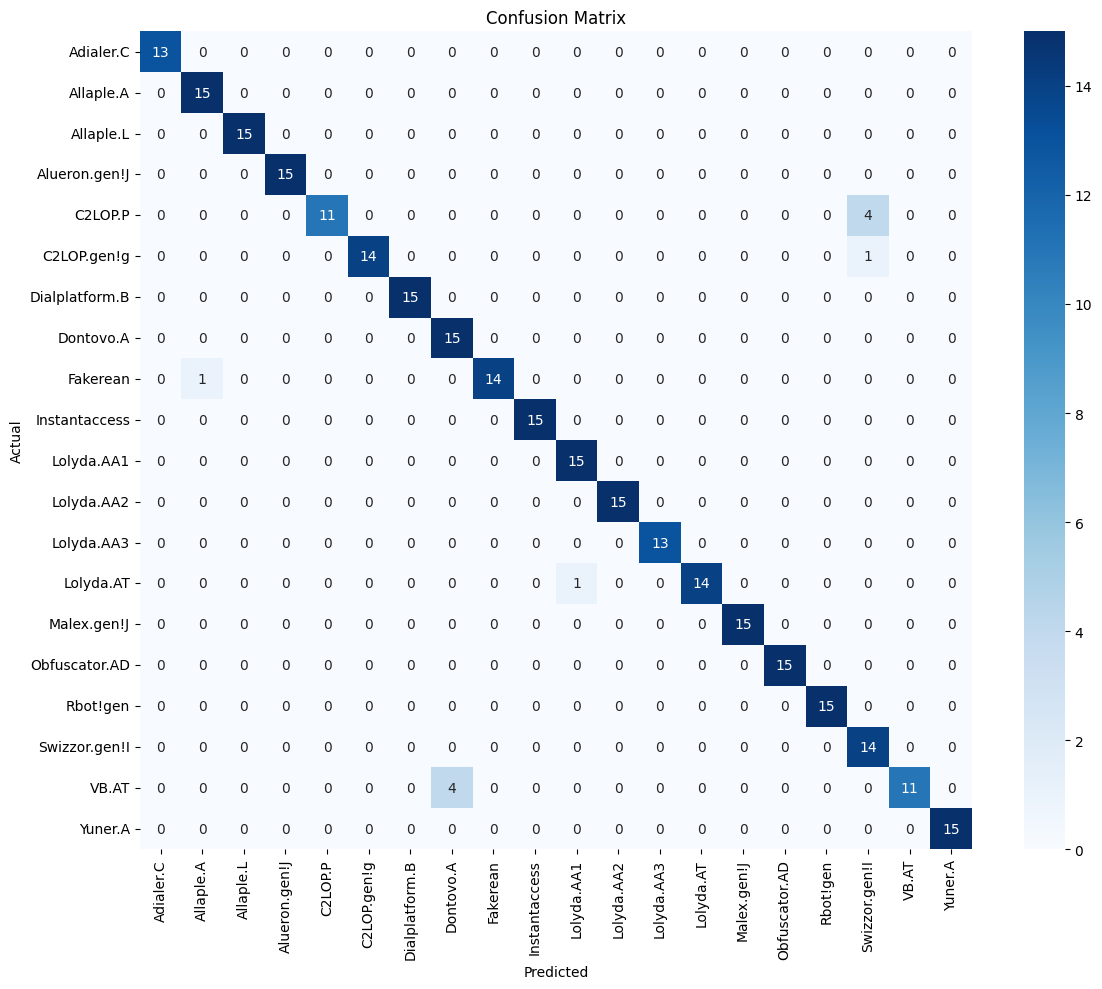


📊 Accuracy per family:
        Family  Accuracy  Precision   Recall  F1 Score
     Adialer.C  1.000000   1.000000 1.000000  1.000000
     Allaple.L  1.000000   1.000000 1.000000  1.000000
Dialplatform.B  1.000000   1.000000 1.000000  1.000000
   C2LOP.gen!g  1.000000   1.000000 1.000000  1.000000
    Lolyda.AA2  1.000000   1.000000 1.000000  1.000000
    Lolyda.AA3  1.000000   1.000000 1.000000  1.000000
 Instantaccess  1.000000   1.000000 1.000000  1.000000
      Fakerean  1.000000   1.000000 1.000000  1.000000
 Obfuscator.AD  1.000000   1.000000 1.000000  1.000000
     Allaple.A  0.933333   0.500000 0.466667  0.482759
   Malex.gen!J  0.933333   0.500000 0.466667  0.482759
         VB.AT  0.600000   0.333333 0.200000  0.250000
 Swizzor.gen!I  0.500000   0.333333 0.166667  0.222222
       C2LOP.P  0.400000   0.500000 0.200000  0.285714
 Alueron.gen!J  0.266667   0.250000 0.066667  0.105263
     Dontovo.A  0.000000   0.000000 0.000000  0.000000
    Lolyda.AA1  0.000000   0.000000 0.000

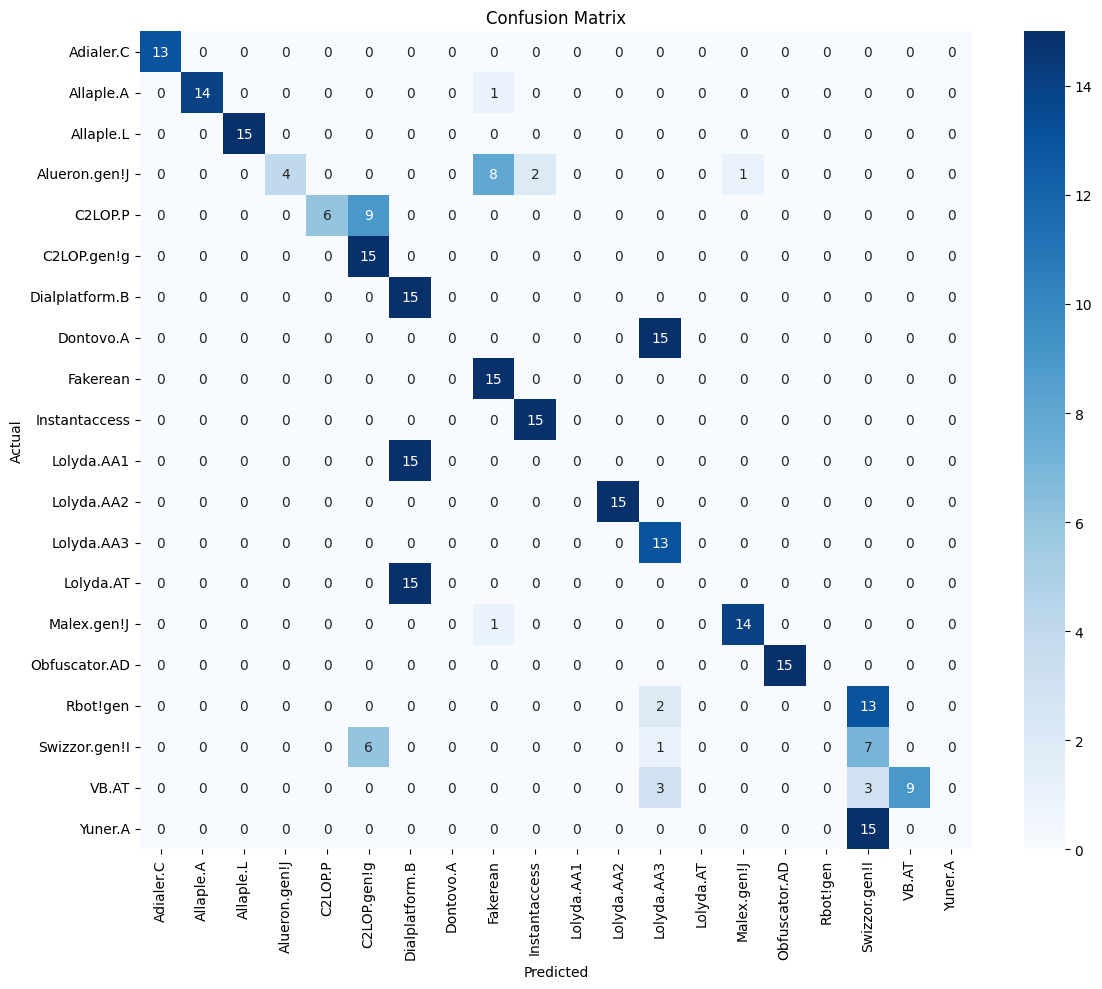

In [40]:
overall_acc, results_df = evaluate_vit_by_family(vit_model_obub, obub_test_loader, obub_test_dataset,"/kaggle/working/ubub.png")
overall_acc, results_df = evaluate_vit_by_family(vit_model, obub_test_loader, obub_test_dataset,"/kaggle/working/ubog.png")

In [41]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define dataset path
DATASET_PATH = "/kaggle/working/obfuscated_malimg/combined"

# Define image transformations for ViT
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.Resize((224, 224)),  # ViT requires a fixed input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1,1]
])

# Load datasets
obc_train_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "train"), transform=transform)
obc_val_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "val"), transform=transform)
obc_test_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "test"), transform=transform)

# Create DataLoaders
BATCH_SIZE = 32
obc_train_loader = DataLoader(obc_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
obc_val_loader = DataLoader(obc_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
obc_test_loader = DataLoader(obc_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check dataset details
print(f"Training samples: {len(obc_train_dataset)}")
print(f"Validation samples: {len(obc_val_dataset)}")
print(f"Testing samples: {len(obc_test_dataset)}")
print(f"Classes: {obc_train_dataset.classes}")

Training samples: 1995
Validation samples: 288
Testing samples: 295
Classes: ['Adialer.C', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Swizzor.gen!I', 'VB.AT', 'Yuner.A']


In [42]:
import timm
import torch.nn as nn
import torch.optim as optim

# Load a pretrained Vision Transformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model_obc = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(obc_train_dataset.classes))

# Move model to device
vit_model_obc = vit_model_obc.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit_model_obc.parameters(), lr=3e-4, weight_decay=1e-4)

In [43]:
import random
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # For better progress visualization

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# # Since we're using all classes, we don't need to filter the dataset
# # Just create DataLoaders directly from the full datasets
# BATCH_SIZE = 32
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# # Define device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(vit_model.parameters(), lr=3e-4, weight_decay=1e-4)

# Print information about the training setup
print(f"✅ Training on all {len(obc_train_dataset.classes)} malware families")
print(f"📊 Training samples: {len(obc_train_dataset)}, Validation samples: {len(obc_val_dataset)}")

# Training function with progress tracking
def train_vit_with_progress(model, train_loader, val_loader, epochs=5, print_every=10):
    model.train()
    
    for epoch in range(epochs):
        print(f"\n🚀 Epoch [{epoch+1}/{epochs}]")
        total_loss = 0
        correct, total = 0, 0
        
        # Use tqdm for progress tracking
        batch_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")
        for batch_idx, (images, labels) in batch_iterator:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            # Print progress every N batches
            if (batch_idx + 1) % print_every == 0:
                batch_acc = correct / total
                batch_iterator.set_postfix(loss=total_loss / (batch_idx + 1), acc=batch_acc)
        # Compute training and validation accuracy
        train_acc = correct / total
        val_acc = evaluate_vit(model, val_loader)
        print(f"📊 Epoch {epoch+1}: Loss: {total_loss / len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Validation function
def evaluate_vit(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Train ViT with Progress Tracking
train_vit_with_progress(vit_model_obc, obc_train_loader, obc_val_loader, epochs=5, print_every=10)


✅ Training on all 20 malware families
📊 Training samples: 1995, Validation samples: 288

🚀 Epoch [1/5]


Training: 100%|██████████| 63/63 [01:15<00:00,  1.19s/it, acc=0.247, loss=2.38] 


📊 Epoch 1: Loss: 2.3070, Train Acc: 0.2627, Val Acc: 0.6493

🚀 Epoch [2/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.19s/it, acc=0.749, loss=0.685]


📊 Epoch 2: Loss: 0.6759, Train Acc: 0.7514, Val Acc: 0.8646

🚀 Epoch [3/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.19s/it, acc=0.877, loss=0.338]


📊 Epoch 3: Loss: 0.3313, Train Acc: 0.8802, Val Acc: 0.8854

🚀 Epoch [4/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.19s/it, acc=0.906, loss=0.245]


📊 Epoch 4: Loss: 0.2562, Train Acc: 0.9048, Val Acc: 0.8472

🚀 Epoch [5/5]


Training: 100%|██████████| 63/63 [01:14<00:00,  1.19s/it, acc=0.922, loss=0.222]


📊 Epoch 5: Loss: 0.2176, Train Acc: 0.9228, Val Acc: 0.8785



📊 Accuracy per family:
        Family  Accuracy  Precision   Recall  F1 Score
     Allaple.A  1.000000        1.0 1.000000  1.000000
     Allaple.L  1.000000        1.0 1.000000  1.000000
Dialplatform.B  1.000000        1.0 1.000000  1.000000
       C2LOP.P  1.000000        1.0 1.000000  1.000000
       Yuner.A  1.000000        1.0 1.000000  1.000000
      Rbot!gen  1.000000        1.0 1.000000  1.000000
     Dontovo.A  1.000000        1.0 1.000000  1.000000
      Fakerean  1.000000        1.0 1.000000  1.000000
    Lolyda.AA2  1.000000        1.0 1.000000  1.000000
    Lolyda.AA1  1.000000        1.0 1.000000  1.000000
     Lolyda.AT  1.000000        1.0 1.000000  1.000000
    Lolyda.AA3  1.000000        1.0 1.000000  1.000000
         VB.AT  0.933333        0.5 0.466667  0.482759
 Alueron.gen!J  0.933333        0.5 0.466667  0.482759
 Instantaccess  0.933333        0.5 0.466667  0.482759
 Swizzor.gen!I  0.928571        0.5 0.464286  0.481481
 Obfuscator.AD  0.866667        0.5 0.433

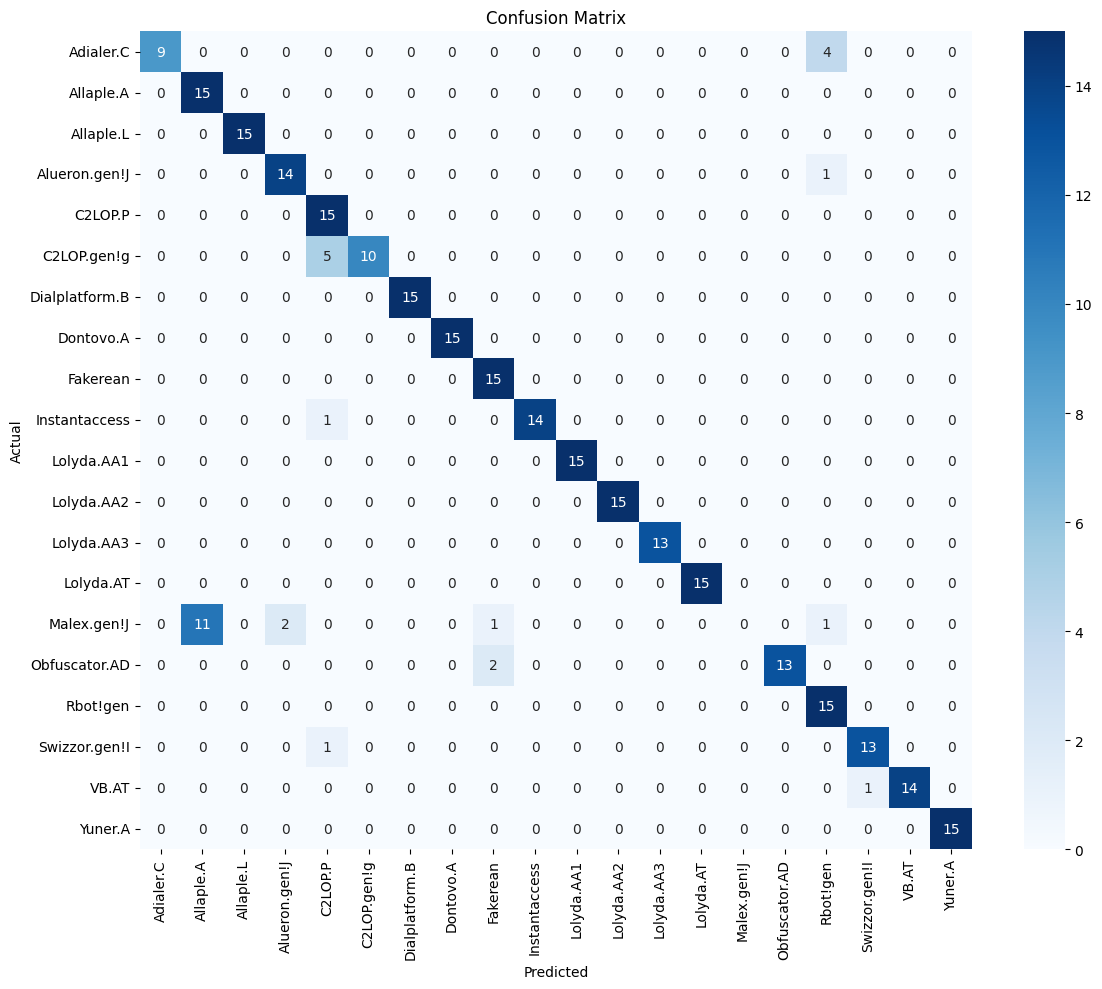


📊 Accuracy per family:
        Family  Accuracy  Precision   Recall  F1 Score
    Lolyda.AA3  1.000000   1.000000 1.000000  1.000000
Dialplatform.B  1.000000   1.000000 1.000000  1.000000
    Lolyda.AA2  0.666667   0.333333 0.222222  0.266667
 Swizzor.gen!I  0.071429   0.333333 0.023810  0.044444
         VB.AT  0.066667   0.333333 0.022222  0.041667
     Allaple.L  0.000000   0.000000 0.000000  0.000000
     Allaple.A  0.000000   0.000000 0.000000  0.000000
     Adialer.C  0.000000   0.000000 0.000000  0.000000
 Alueron.gen!J  0.000000   0.000000 0.000000  0.000000
     Dontovo.A  0.000000   0.000000 0.000000  0.000000
   C2LOP.gen!g  0.000000   0.000000 0.000000  0.000000
       C2LOP.P  0.000000   0.000000 0.000000  0.000000
    Lolyda.AA1  0.000000   0.000000 0.000000  0.000000
 Instantaccess  0.000000   0.000000 0.000000  0.000000
      Fakerean  0.000000   0.000000 0.000000  0.000000
     Lolyda.AT  0.000000   0.000000 0.000000  0.000000
 Obfuscator.AD  0.000000   0.000000 0.000

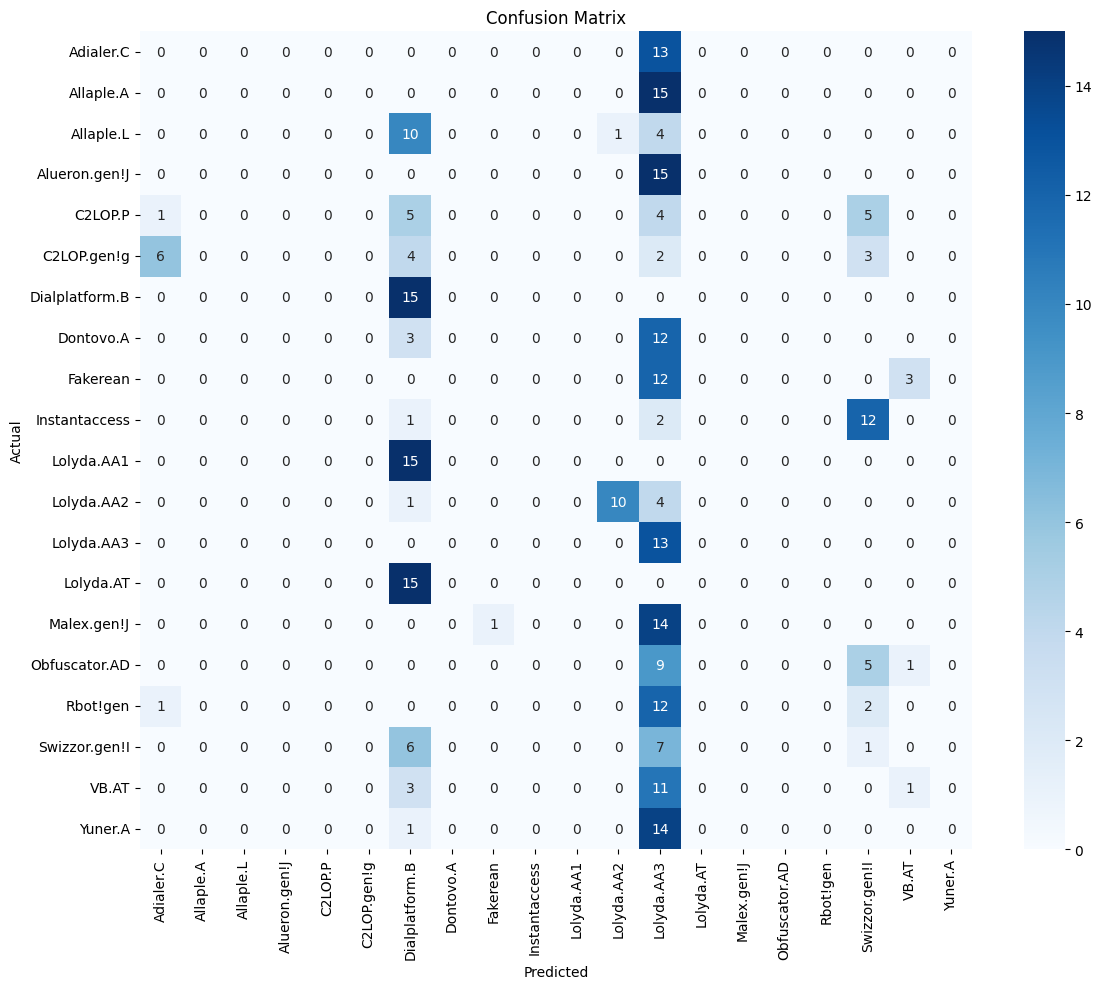

In [44]:
overall_acc, results_df = evaluate_vit_by_family(vit_model_obc, obc_test_loader, obc_test_dataset,"/kaggle/working/cc.png")
overall_acc, results_df = evaluate_vit_by_family(vit_model, obc_test_loader, obc_test_dataset,"/kaggle/working/cog.png")